# Detailed Data Analysis: kochbar.de

### Table of contents:
1. Exploratory Analysis
    - General information
    - Users
    - Recipes
    - Text Mining
        - Title Analysis
        - Ingredient Analysis
        - Feature Extraction
2. Trend Analysis
3. Data Mining

# 1. Exploratory Analysis

## General statistics & Data quality

First, we do all necessary imports and convert the data from its list format to a pandas DataFrame for further operations.
Then, we show meta information about density/sparsity of each column.

### Import packages and data

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Read json file into a list
with open('data/kochbar_03.json') as data_file:    
    kochbar = json.load(data_file)

### Data structure

To understand the data structure that the scraper has exported, we can take a look at the first element from the list kochbar.
This is a dictionary that contains a single recipe.

In [4]:
kochbar[0]

{'avg_rating': '4,83',
 'calories': '933 (223)',
 'clicks': '101092',
 'comment_number': '59',
 'date': '26.07.2009',
 'difficulty': 'leicht',
 'favorites': '925',
 'ingredients': '500   gr. Hackfleisch    3    Zucchini    1   Btl. Spätzle, fertige   Salz, Pfeffer   Knoblauchzehe    1   Pck. Kräuterfrischkäse, 200gr.    1   Becher süße Sahne    2   Eßl. frische Petersilie, gehackt   Salz, Knoblauchgranulat    4    Eier',
 'name': 'Zucchini-Hackauflauf mit Frischkäse und Spätzle ',
 'number_votes': '141',
 'preparation': '    1  Das  Hackfleisch mit etwas Margarine in der Pfanne krümelig anbraten.\rZucchini waschen, halbieren und mit einem Teelöffel die Kerne entfernen, dann in Scheibchen schneiden. dazugeben und kurz mitbraten. Salzen und Pfeffern,  Knobi auspressen, dazugeben und abschmecken.2  Alles in eine Auflaufform geben und die Spätzle unterheben.\rDen Kräuterfrischkäse mit der Sahne und den Eiern glattrühren, die gehackte Petersilie mit einrühren. Mit Salz und Pfeffer und Knobl

Thus, we can see that our dataset is a list of dictionaries, of which each is a single recipe. The dictionary itself consists of text fields that are all either filled with a string or None, if they are empty.

In [5]:
# The json is imported as a list of dictionaries filled with strings
type(kochbar), type(kochbar[0]), type(kochbar[0]['name'])

(list, dict, str)

In [6]:
# Splitting the date and creating new columns for year, month and day:
date = []
for i, r in enumerate(kochbar):
    date = kochbar[i]['date'].split('.')
    kochbar[i]['year'] = date[2]
    kochbar[i]['month'] = date[1]
    kochbar[i]['day'] = date[0]

In [7]:
kochdf = pd.DataFrame(kochbar)
kochdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413769 entries, 0 to 413768
Data columns (total 19 columns):
avg_rating        413769 non-null object
calories          413769 non-null object
clicks            413769 non-null object
comment_number    413769 non-null object
date              413769 non-null object
day               413769 non-null object
difficulty        413769 non-null object
favorites         413769 non-null object
ingredients       413769 non-null object
month             413769 non-null object
name              413769 non-null object
number_votes      413769 non-null object
preparation       413769 non-null object
price             413769 non-null object
subtitle          208236 non-null object
time_hrs          971 non-null object
time_mins         279540 non-null object
user              407539 non-null object
year              413769 non-null object
dtypes: object(19)
memory usage: 60.0+ MB


The numeric fields need to be converted to their respective data format, so we can perform calculations with them, for example by summing or calculating the mean:

In [8]:
kochdf['avg_rating'] = pd.to_numeric(kochdf['avg_rating'].str.replace(',','.'))
kochdf['clicks'] = pd.to_numeric(kochdf['clicks'])
kochdf['comment_number'] = pd.to_numeric(kochdf['comment_number'])
kochdf['favorites'] = pd.to_numeric(kochdf['favorites'])
kochdf['number_votes'] = pd.to_numeric(kochdf['number_votes'])
kochdf['time_mins'] = pd.to_numeric(kochdf['time_mins'])
kochdf['date'] = pd.to_datetime(kochdf['date'], format="%d.%m.%Y")

# kochdf.info()  # uncomment for printout

In [9]:
# Total number of unique active users (at least 1 recipe published)
len(kochdf['user'].value_counts())

18613

There are 18,613 distinct users on kochbar.de, which have published at least one recipe.

- How many recipes have been published on this platform?

In [10]:
len(kochdf['date'])

413769

- When were the first recipes published?

In [11]:
print(kochdf['date'].nsmallest(10))

86470    2008-03-08
3135     2008-03-09
13903    2008-03-09
19502    2008-03-09
40327    2008-03-09
413281   2008-03-11
4447     2008-03-12
7220     2008-03-12
7358     2008-03-12
10376    2008-03-12
Name: date, dtype: datetime64[ns]


- How many times have the users voted?

In [29]:
print(kochdf['number_votes'].sum())

7570275


- Calculating deltas

For comparing the main statistics with older dataset versions, we will use the 1 month (koch1 / koch1df) and 6 months (koch6 / koch6df) older versions.

First, koch1:

In [32]:
with open('data/kochbar_02.json') as data_file:    
    koch1 = json.load(data_file)
koch1df = pd.DataFrame(koch1)
koch1df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420582 entries, 0 to 420581
Data columns (total 16 columns):
avg_rating        420582 non-null object
calories          420582 non-null object
clicks            420582 non-null object
comment_number    420582 non-null object
date              420582 non-null object
difficulty        420582 non-null object
favorites         420582 non-null object
ingredients       420582 non-null object
name              420582 non-null object
number_votes      420582 non-null object
preparation       420582 non-null object
price             420582 non-null object
subtitle          212071 non-null object
time_hrs          996 non-null object
time_mins         283289 non-null object
user              414311 non-null object
dtypes: object(16)
memory usage: 51.3+ MB


In [34]:
# Number of recipes
print(len(koch1df['name']))
print(len(kochdf['name'])-len(koch1df['name']))

420582
-6813


In [26]:
# Number of distinct authors
print(len(koch1df['user'].value_counts()))
print(len(kochdf['user'].value_counts())-len(koch1df['user'].value_counts()))

18694
-81


In [27]:
# Number of total votes
koch1df['number_votes'] = pd.to_numeric(koch1df['number_votes'])
print(koch1df['number_votes'].sum())
print(kochdf['number_votes'].sum()-koch1df['number_votes'].sum())

7741756
-171481


Now we cann do the same for koch6:

In [19]:
with open('data/kochbar_10.json') as data_file:    
    koch6 = json.load(data_file)    
koch6df = pd.DataFrame(koch6)
koch6df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330716 entries, 0 to 330715
Data columns (total 16 columns):
avg_rating        330716 non-null object
calories          330716 non-null object
clicks            330716 non-null object
comment_number    330716 non-null object
date              330716 non-null object
difficulty        330716 non-null object
favorites         330716 non-null object
ingredients       330716 non-null object
name              330716 non-null object
number_votes      330716 non-null object
preparation       330716 non-null object
price             330716 non-null object
subtitle          167695 non-null object
time_hrs          928 non-null object
time_mins         221891 non-null object
user              325828 non-null object
dtypes: object(16)
memory usage: 40.4+ MB


In [35]:
# Number of recipes
print(len(koch6df['name']))
print(len(kochdf['name'])-len(koch6df['name']))

330716
83053


In [28]:
# Number of distinct authors
print(len(koch6df['user'].value_counts()))
print(len(kochdf['user'].value_counts())-len(koch6df['user'].value_counts()))

17216
1397


In [30]:
# Number of total votes
koch6df['number_votes'] = pd.to_numeric(koch6df['number_votes'])
print(koch6df['number_votes'].sum())
print(kochdf['number_votes'].sum()-koch6df['number_votes'].sum())

6242074
1328201


#### Missing values
Almost all columns/attributes have a value in every recipe (data point), but some columns like subtitle, time_hrs, time_mins and user are only filled partly. More specifically, while user is only empty in 1.5% of the data points, subtitle and time_mins are empty in approximately half of the cases and time_hrs is merely provided for 917 of 413,769 recipes, which is only 0.22% of the data.
Thus, the column time_hrs is useless for further analysis.

#### Dirty data
After handling the missing values, we need to check if the available data is actually correct, i.e. if all numeric fields like rating or number of clicks actually contain numeric values.
A quick test shows that the calories attribute is not clean, as it often contains the word "Eiweiß" (protein) or "-" instead of the amount of calories:

In [20]:
for r in kochbar[:10]:
    print(r['calories'])

933 (223)
1838 (439)
1884 (450)
-
1712 (409)
883 (211)
Eiweiß
2323 (555)
251 (60)
699 (167)


In [13]:
kochdf['calories'].value_counts()[:10]

Eiweiß        135450
-              28902
200 (48)        1350
305 (73)        1301
1268 (303)      1275
1695 (405)      1219
3701 (884)      1190
937 (224)       1171
79 (19)         1070
255 (61)        1021
Name: calories, dtype: int64

A large number of the 413,769 recipes have the word "Eiweiß" (135,450 ~ 33%) or just "-" (28,902 ~ 7%) instead of the calories values, which means that approximately 40% of the values are unusable.

Thus, there is not much use for the columns 'calories' and 'time_hrs', because their data quality is too low.
They can be dropped:

In [14]:
kochdf = kochdf.drop(['calories', 'time_hrs'], axis=1)

## Users

What can we learn about the users of this website?
Main questions are:
- Which users have contributed the largest number of recipes?
- Which users are the most successful/efficient?
- Which recipes have made these users so successful?

From a business perspective, we want to find the users that have published successful recipes consistently, as they would be a valuable source for selecting recipes to feature in our service.

### Creating the features

For the analysis in this section, we will create a separate DataFrame for performing the necessary operations. In the following, we will pursue multiple steps to create an informative overview on the most active users of this platform.

- Add the count of recipes for each user:

In [14]:
# Show users with most contribution in terms of recipe count
recipe_count = pd.DataFrame(kochdf['user'].value_counts())
recipe_count.columns = ['recipe_count']

- How many clicks has each user "collected" with his/her recipes in total?

In [15]:
# Add sum of clicks per user
clicks = pd.DataFrame(kochbar, columns=['user', 'clicks'])
clicks['clicks'] = pd.to_numeric(clicks['clicks'])  # needs to be done for each new data frame
clicks = clicks.groupby('user').sum()
topusers = recipe_count.join(clicks)

- What is the average click count per recipe for each user?

There is an easy way to calculate this attribute:

In [16]:
# How many clicks are these users getting per recipe on average?
topusers['clicks_per_recipe'] = topusers['clicks'] / topusers['recipe_count']

- What is the median click count per recipe for each user? (This is interesting, as the median is much more robust regarding outliers)

In [17]:
# The median of clicks could also be interesting, 
#  as it is more robust than the average on exponential data
median_clicks = pd.DataFrame(kochbar, columns=['user', 'clicks'])
median_clicks['clicks'] = pd.to_numeric(median_clicks['clicks'])
median_clicks = median_clicks.groupby('user').median()

# need to rename the columns before joining
median_clicks.columns = ['median_clicks']  
topusers = topusers.join(median_clicks)

- What is the users' average rating?

In [18]:
# What is the average recipe rating per user?
rating = pd.DataFrame(kochbar, columns=['user', 'avg_rating'])
rating['avg_rating'] = pd.to_numeric(rating['avg_rating'].str.replace(',','.'))
rating = rating.groupby('user').mean()

# Adding this to our topusers dataframe:
topusers = topusers.join(rating)

- How many votes has each user collected with his/her recipes?

In [19]:
# How many votes have they received
votes = pd.DataFrame(kochbar, columns=['user', 'number_votes'])
votes['number_votes'] = pd.to_numeric(votes['number_votes'])
votes = votes.groupby('user').sum()

# Adding this to our topusers dataframe:
topusers = topusers.join(votes)

- How many have rated recipes as favorites per user?

In [20]:
# How many favorites have they received
faves = pd.DataFrame(kochbar, columns=['user', 'favorites'])
faves['favorites'] = pd.to_numeric(faves['favorites'])
faves = faves.groupby('user').sum()

# Adding this to our topusers dataframe:
topusers = topusers.join(faves)

We should also consider the fact that all of these attributes accumulate over time. For this purpose, we should add another feature that shows have passed since the user published his/her first recipe on the platform.

- For how many days has each user been active?

In [21]:
# For how long has a user been active
days = pd.DataFrame(kochbar, columns=['user', 'date'])
days['date'] = pd.to_datetime(days['date'], format="%d.%m.%Y")
days = days.groupby('user').min()  # shows the earliest publication date per user

In [22]:
# We can write a function for calculating the number of days between two dates
from datetime import datetime
end = kochdf['date'].max()  # Consider the latest recipe date as "today"
def days_passed(d1):
    return abs((end - d1).days)  # returns the number of days only

In [23]:
# Now we calculate the days that have passed since then:  
days['days'] = days['date'].apply(days_passed)
days = days.drop(['date'], axis=1)

# Adding this to the topusers dataframe:
topusers = topusers.join(days)

Based on these attributes, we can now calculate further metrics that help understanding the dataset better.
For example: the average clicks per recipe and the ratio between number of votes and number of recipes for each user.
If we assume that a high amount of clicks does not necessarily mean that the recipe is good, we will need to consider the second popularity metric, that is available in this dataset: the number of votes.
However, as the number of votes is usually significantly lower than the number of clicks, this assumption could be wrong, as clearly fewer users take the time to vote for a recipe. This might be due to the reason that for rating a recipe, you usually would first cook the recipe and then come back to the website and rate based on your experience.

- Still, we can create a feature for the number of votes per recipe:

In [24]:
# Average number of votes per recipe
topusers['votes_per_recipe'] = topusers['number_votes'] / topusers['recipe_count']

Finally, we can create two attributes that are normalised by days. We want to avoid divisions of or by zero, which would lead to NaN or infinite values.

In [47]:
print("Users with 0 favorite votes: "+str(len(topusers.loc[topusers['favorites'] == 0])))  
print("Users with 0 days: "+str(len(topusers.loc[topusers['days'] == 0])))

Users with 0 favorite votes: 2223
Users with 0 days: 1


In [48]:
topusers['clicks_per_day'] = topusers['clicks'] / (topusers['days']+1)
topusers['fav_per_day'] = (topusers['favorites']+0.001) / (topusers['days']+1)

Of course, there are many more features possible, e.g. the ratios favorites/recipe_count, favorites/clicks, votes/clicks or number_of_votes/days. In a very thorough analysis, those attributes should also be calculated and analysed. 
Basically, all attributes could be normalised through dividing by the number of days.
For simplicity reasons, the attributes viewed in this part of the project will be limited to the ones that have been created above.

### Top users overview

Now we can look at all these statistics in our DataFrame.

In [49]:
# topusers = topusers.sort_values(by='clicks',ascending=False)  # Uncomment if it should be sorted by clicks
topusers.head(10)

,recipe_count,clicks,clicks_per_recipe,median_clicks,avg_rating,number_votes,favorites,days,votes_per_recipe,clicks_per_day,fav_per_day
Das perfekte Dinner,8364,17616144,2106.186514,1196.5,4.801077,14139,57057,3642,1.690459,4835.614603,15.662092
schnuffelohr,5816,2784642,478.789890,215.0,4.955186,102082,12993,3551,17.551926,783.964527,3.657939
Chefkoch1940,2801,1696411,605.644770,321.0,4.968958,59274,7568,3218,21.161728,526.999379,2.351041
imhbach,2613,3499886,1339.412935,667.0,4.980991,58459,10624,3159,22.372369,1107.558861,3.362026
Das perfekte Promi-Dinner,2319,4766553,2055.434670,1215.0,4.806653,2917,11025,3579,1.257870,1331.439385,3.079609
Publicity,2279,3133514,1374.951294,753.0,4.982133,71123,9804,3193,31.207986,981.062617,3.069506
mimi,2180,12696078,5823.888991,1909.5,4.963206,80937,38158,3548,37.127064,3577.367709,10.751761
Unter Volldampf,2006,3626977,1808.064307,1142.0,4.814978,2526,13135,3622,1.259222,1001.097709,3.625449
rainbow3,2002,9942473,4966.270230,2440.0,4.980839,63646,17956,2917,31.791209,3407.290267,6.153530
chucky,1956,1081335,552.829755,284.0,4.943969,16438,2746,3474,8.403885,311.175540,0.790216


This table shows the generated features sorted by the most active users regarding recipe count. As kochbar.de is working in cooperation with the German TV Channel Vox, the official user accounts of the two cooking shows "Das perfekte Dinner" and "Das perfekte Promi-Dinner" are highly active.
Still, the fact that so many private users are able to keep up with that professional performance shows how actively those are engaged in the community.

### Data distributions and skewness

For further understanding, we can take a look at how the data is distributed. Viewing histograms and measures of central value as well as percentiles can be very useful for this task:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E8BF5F2748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001E8BF2B61D0>]], dtype=object)

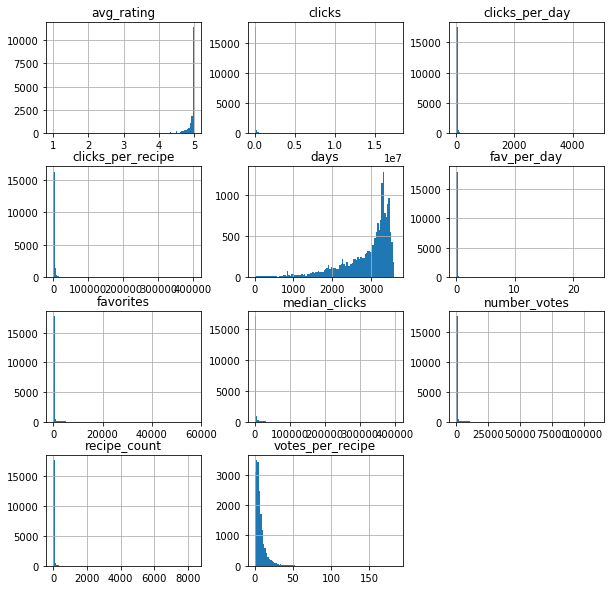

In [50]:
# How is the data distributed?
topusers.hist(bins=100, figsize=(10,10))

In [51]:
# Show basic statistics (count, percentiles and measures of central value)
topusers.describe()

,recipe_count,clicks,clicks_per_recipe,median_clicks,avg_rating,number_votes,favorites,days,votes_per_recipe,clicks_per_day,fav_per_day
count,18613.000000,1.861300e+04,18613.000000,18613.000000,17714.000000,18613.000000,18613.000000,18613.000000,18613.000000,18613.000000,1.861300e+04
mean,21.895396,5.177019e+04,2383.553741,1715.827056,4.884422,400.645409,145.045936,2870.429162,7.356724,17.700318,5.091354e-02
std,118.294265,3.155489e+05,7000.425289,5721.231654,0.325142,3037.848547,1032.972745,696.024671,8.401859,100.898215,3.728298e-01
min,1.000000,2.400000e+01,24.000000,24.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.014047,2.781641e-07
25%,1.000000,1.027000e+03,529.000000,393.000000,4.916667,4.000000,2.000000,2579.000000,2.500000,0.383756,6.444444e-04
50%,3.000000,4.144000e+03,1035.000000,707.000000,4.990000,16.000000,7.000000,3147.000000,5.000000,1.529094,2.683646e-03
75%,10.000000,1.796800e+04,2252.360656,1499.000000,5.000000,71.000000,35.000000,3348.000000,9.000000,6.487172,1.254540e-02
max,8364.000000,1.761614e+07,402418.000000,402418.000000,5.000000,110322.000000,57057.000000,3646.000000,184.000000,4835.614603,2.404810e+01


The histograms show a high (positive or negative) skewness in each attribute. This means that there is a small number of users that is highly active, publishing many recipes and collecting high ratings. At the same time, there is a very large number of users that contribute significantly less, which is why the data is strongly skewed with regards to practically all of these attributes.

We can see that more than 75% of all users have received an average rating of 4.917 stars (out of 5) or above with at least 25% of the users having the maximum rating of 5 stars, which makes it difficult to use this attribute as valuable information. Thus, this attribute can rather be used to filter the relatively unpopular users, which have actually managed to receive a rating worse than 4 or 4.5.
The attributes recipe_count, clicks_per_recipe and number_votes show their skewness in the differences between mean and median (or between 75% percentile and maximum). Still, these attributes could be used for further insights, as they are not capped like avg_rating.

An approach of handling the skewness could be to transform and normalize the data fields by using a logarithmic transformation and then shifting the mean to zero to achieve a certain degree of normalisation. However, this would not work for avg_rating, more than 25% of ratings have hit the "barrier" of 5.0, which is due to the nature of the rating scale. Thus, for that field, a transformation could not provide further insight.
Additionally, transformations can strongly reduce the interpretability of attributes, as the more these values are transformed, the further away they are from their easy-to-understand real value, which a reader can relate to.

In [192]:
# Which users have the highest "click efficiency" (collected most clicks with fewest recipes)?
user_efficiency = topusers.sort_values(by='clicks_per_recipe',ascending=False)
top_efficiency = user_efficiency.loc[user_efficiency["recipe_count"]>=5]  # with more than 10 recipes published
top_efficiency.head(10)

,recipe_count,clicks,clicks_per_recipe,median_clicks,avg_rating,number_votes,favorites,days,votes_per_recipe,clicks_per_day,fav_per_day,user
mareikus,7,1558124,222589.142857,29746.0,4.885714,353,1231,3316,50.428571,469.738921,0.371119,mareikus
saaahraaa,9,1494471,166052.333333,7254.0,4.941111,147,382,2726,16.333333,548.027503,0.140081,saaahraaa
Eni0,5,634460,126892.000000,1004.0,4.950000,170,748,3185,34.000000,199.139987,0.234777,Eni0
zaphi67,36,4063146,112865.166667,3759.0,4.958056,803,1206,3231,22.305556,1257.161510,0.373144,zaphi67
Kruemelmonster,9,967351,107483.444444,12022.0,4.748889,412,875,3572,45.777778,270.739155,0.244893,Kruemelmonster
SweetDevil77,5,462974,92594.800000,1613.0,4.624000,42,199,1647,8.400000,280.930825,0.120753,SweetDevil77
sabi7224,6,521995,86999.166667,2125.0,4.985000,58,827,3375,9.666667,154.619372,0.244965,sabi7224
Zauberelfe,5,403348,80669.600000,2490.0,4.942000,26,41,3442,5.200000,117.150160,0.011909,Zauberelfe
KB_Redaktion,25,1936587,77463.480000,6327.0,4.893333,116,3529,1032,4.640000,1874.721200,3.416264,KB_Redaktion
Seety,6,344918,57486.333333,1184.5,4.968333,51,259,3380,8.500000,102.016563,0.076605,Seety


None of the top 20 efficient users (except for zaphi67) has published more than 9 recipes. Thus, this DataFrame has been queried for all users that have more than 10 recipes published.
We can take a look at the histograms for a small subset of users and we will see, that there is still an exponential distribution in most of the attributes:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E8BF36DB70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001E8B31C4198>]], dtype=object)

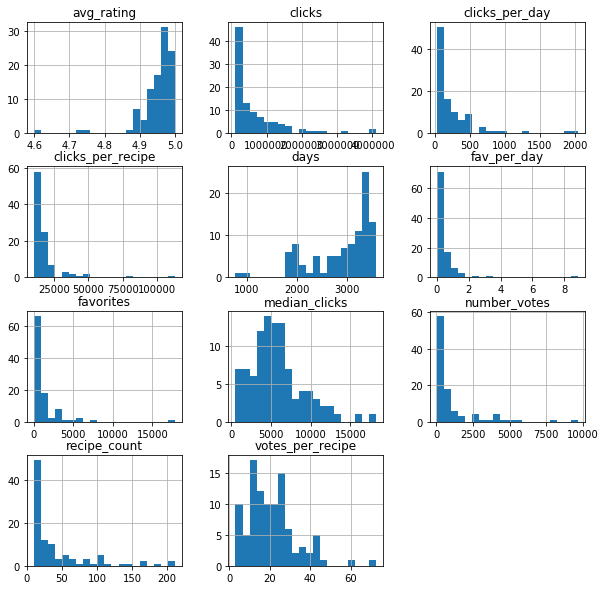

In [54]:
# Histograms for top 100 efficient users
top_efficiency.head(100).hist(bins=20, figsize=(10,10))

Now we can look at the top users from a different perspective: their ability to collect rating votes for their recipes.

In [55]:
# Sort by average votes
vote_efficiency = topusers.sort_values(by='votes_per_recipe',ascending=False)
vote_efficiency.head(10)

,recipe_count,clicks,clicks_per_recipe,median_clicks,avg_rating,number_votes,favorites,days,votes_per_recipe,clicks_per_day,fav_per_day
rocky041151,1,8803,8803.000000,8803.0,4.980000,184,42,2741,184.000000,3.210430,0.015318
Schokoprinzessin,4,693927,173481.750000,119044.5,4.805000,600,1566,3319,150.000000,209.014157,0.471687
freeminds,1,3833,3833.000000,3833.0,4.970000,128,81,3319,128.000000,1.154518,0.024398
kullerkeks,1,218309,218309.000000,218309.0,4.440000,105,341,3407,105.000000,64.057805,0.100059
Jey81,1,21909,21909.000000,21909.0,5.000000,101,101,2957,101.000000,7.406694,0.034145
schwarz_pfeffer,41,212457,5181.878049,3088.0,4.916341,4026,1993,3257,98.195122,65.210866,0.611725
Noriana,103,627016,6087.533981,4414.0,4.988932,10066,4320,1977,97.728155,316.994944,2.184025
rosinenschneckele,458,1161056,2535.056769,1018.5,4.966354,42939,12423,3293,93.753275,352.476017,3.771403
Erinnerung,1,643,643.000000,643.0,4.900000,93,16,3020,93.000000,0.212843,0.005297
rezeptemaus,340,1467402,4315.888235,2061.0,4.976588,30778,4410,3307,90.523529,443.591898,1.333132


### Correlations

In the next step, we can build a scatter matrix to see how these features that we have just created:

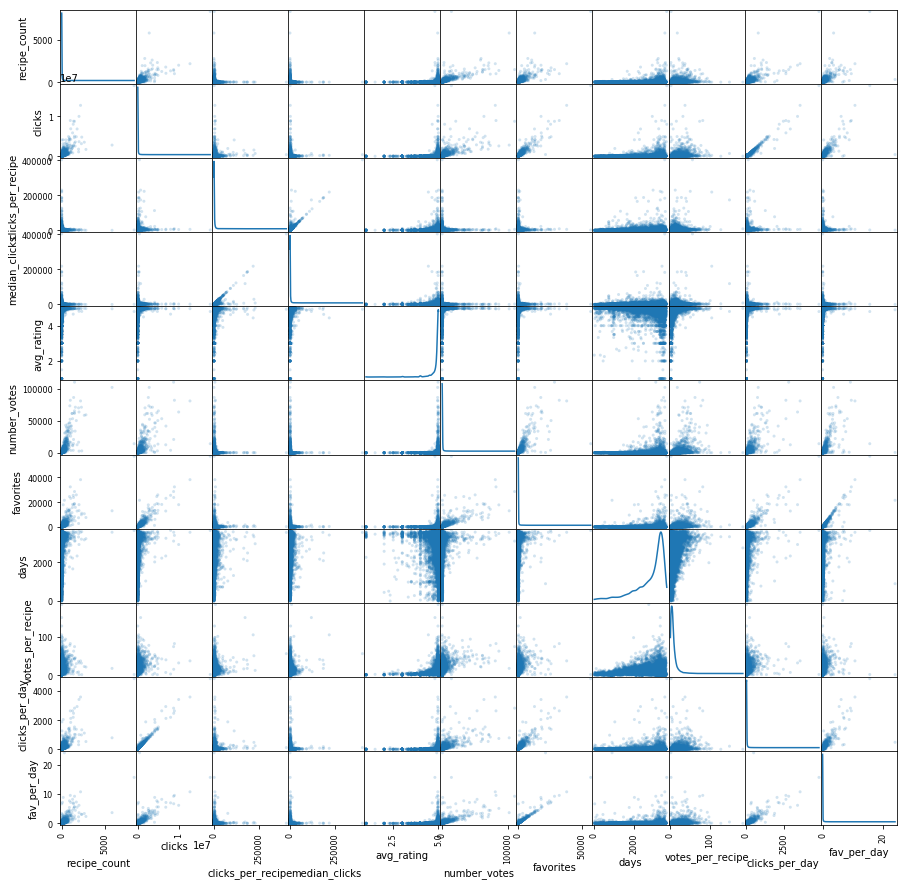

In [56]:
from pandas.plotting import scatter_matrix
_ = scatter_matrix(vote_efficiency, alpha=0.2, figsize=(15, 15), diagonal='kde')

The scatter matrix shows pairwise distributions and provides information about each attribute's distribution. The diagonal of the matrix shows the Kernel Density Estimates, which are estimates for each attribute's probability density. This can be used to identify the distribution of each attribute. We can see that actually all attributes have a more or less exponential distribution.

We can also see that there seems to be a high correlation between the pairs clicks_per_recipe / median_clicks, favorites / clicks, and favorites / number_votes. However, some of the other attribute pairs should also be checked for dependencies.

To analyse the dependencies in more detail, we can use a correlation coefficient to measure linear dependency between two attributes. The package scipy provides multiple functions for this purpose. We can start by using the Pearson's r, which is the most commonly used correlation coefficient:

In [221]:
# Compute all Pearson r's and their p-Value, which are then stored in lists:
from scipy.stats.stats import pearsonr

def calculate_pearson(df):
    pear = []
    pearp = []
    for i in df:
        pear_i = []
        pearp_i = []
        for j in df:
            pear_i.append(pearsonr(df[i], df[j])[0])
            pearp_i.append(pearsonr(df[i], df[j])[1])
        pear.append(pear_i)
        pearp.append(pearp_i)
    return pear, pearp

C:\Users\buz_t\Anaconda3\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


In [222]:
pear, pearp = calculate_pearson(vote_efficiency)
peardf = pd.DataFrame(pear, columns=vote_efficiency.columns, index=vote_efficiency.columns)
peardf

,recipe_count,clicks,clicks_per_recipe,median_clicks,avg_rating,number_votes,favorites,days,votes_per_recipe,clicks_per_day,fav_per_day
recipe_count,1.000000,0.779083,-0.000506,-0.019751,NaN,0.724105,0.792475,0.063271,0.241052,0.744703,0.670521
clicks,0.779083,1.000000,0.117673,0.034920,NaN,0.702877,0.933847,0.049853,0.315966,0.978824,0.801662
clicks_per_recipe,-0.000506,0.117673,1.000000,0.852625,NaN,0.012393,0.050538,-0.008458,0.249602,0.135592,0.051760
median_clicks,-0.019751,0.034920,0.852625,1.000000,NaN,-0.007650,0.012285,-0.020846,0.194374,0.041175,0.012551
avg_rating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_votes,0.724105,0.702877,0.012393,-0.007650,NaN,1.000000,0.769826,0.046665,0.397664,0.693735,0.664811
favorites,0.792475,0.933847,0.050538,0.012285,NaN,0.769826,1.000000,0.048079,0.331999,0.905548,0.906442
days,0.063271,0.049853,-0.008458,-0.020846,NaN,0.046665,0.048079,1.000000,-0.028888,0.013457,-0.004423
votes_per_recipe,0.241052,0.315966,0.249602,0.194374,NaN,0.397664,0.331999,-0.028888,1.000000,0.323425,0.294459
clicks_per_day,0.744703,0.978824,0.135592,0.041175,NaN,0.693735,0.905548,0.013457,0.323425,1.000000,0.820559


In [91]:
pearpdf = pd.DataFrame(pearp, columns=vote_efficiency.columns, index=vote_efficiency.columns)
pearpdf

,recipe_count,clicks,clicks_per_recipe,median_clicks,avg_rating,number_votes,favorites,days,votes_per_recipe,clicks_per_day,fav_per_day
recipe_count,0.000000e+00,0.000000e+00,9.450117e-01,7.046435e-03,1.0,0.000000e+00,0.000000e+00,5.615666e-18,2.880927e-244,0.000000e+00,0.000000e+00
clicks,0.000000e+00,0.000000e+00,2.204786e-58,1.886437e-06,1.0,0.000000e+00,0.000000e+00,1.009234e-11,0.000000e+00,0.000000e+00,0.000000e+00
clicks_per_recipe,9.450117e-01,2.204786e-58,0.000000e+00,0.000000e+00,1.0,9.088642e-02,5.244447e-12,2.485291e-01,2.539025e-262,4.384532e-77,1.596164e-12
median_clicks,7.046435e-03,1.886437e-06,0.000000e+00,0.000000e+00,1.0,2.966587e-01,9.374813e-02,4.453153e-03,6.787699e-158,1.915735e-08,8.685687e-02
avg_rating,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
number_votes,0.000000e+00,0.000000e+00,9.088642e-02,2.966587e-01,1.0,0.000000e+00,0.000000e+00,1.896919e-10,0.000000e+00,0.000000e+00,0.000000e+00
favorites,0.000000e+00,0.000000e+00,5.244447e-12,9.374813e-02,1.0,0.000000e+00,0.000000e+00,5.284095e-11,0.000000e+00,0.000000e+00,0.000000e+00
days,5.615666e-18,1.009234e-11,2.485291e-01,4.453153e-03,1.0,1.896919e-10,5.284095e-11,0.000000e+00,8.089083e-05,6.637913e-02,5.462494e-01
votes_per_recipe,2.880927e-244,0.000000e+00,2.539025e-262,6.787699e-158,1.0,0.000000e+00,0.000000e+00,8.089083e-05,0.000000e+00,0.000000e+00,0.000000e+00
clicks_per_day,0.000000e+00,0.000000e+00,4.384532e-77,1.915735e-08,1.0,0.000000e+00,0.000000e+00,6.637913e-02,0.000000e+00,0.000000e+00,0.000000e+00


The users with high "click efficiency" (average clicks) are understandably also the ones with high median clicks, which is shown by the high correlation of these two columns. There is actually one dependence that is quite striking: the high correlation between clicks and favorites, which means that favorites cannot be seen as an independent quality indicator, but instead grows almost linearly with the number of clicks.

At the same time, the amount of days since each user's first publication does not seem to influence the other attributes.

Additionally, there is a correlation to some extent between the number of votes and the recipe count that a user has, as well as between number of votes and number of clicks. This can be seen in the scatter matrix as well: especially users with a lower total amount recipes have usually a lower number of total votes and total clicks collected, which also is comprehensible.

It has to be noted that the Pearson r assumes normal distribution and only measure linear dependence between values. This could also be the reason why the calculation of Pearson's r for avg_rating has failed, as that attribute is probably the farthest away from normal distribution. 
To achieve reliable results, we should calculate a different correlation coefficient: The Spearman's rho, which is a rank correlation coefficient, does measure how well the relationship between two attributes can be described with a monotonic function.
This includes linear functions, but is not limited to them. 
(An alternative option to this would be Kendall's tau, which operates in a similar way.)

In [92]:
from scipy.stats.stats import spearmanr
speardf = pd.DataFrame(spearmanr(vote_efficiency)[0], columns=vote_efficiency.columns, index=vote_efficiency.columns)
speardf

,recipe_count,clicks,clicks_per_recipe,median_clicks,avg_rating,number_votes,favorites,days,votes_per_recipe,clicks_per_day,fav_per_day
recipe_count,1.000000,0.824378,0.256433,-0.003880,-0.430514,0.878147,0.824265,0.108938,0.418444,0.803214,0.803170
clicks,0.824378,1.000000,0.726436,0.480442,-0.407353,0.828870,0.895899,0.101252,0.539498,0.977626,0.874929
clicks_per_recipe,0.256433,0.726436,1.000000,0.894333,-0.191505,0.380263,0.545151,0.044847,0.431866,0.711341,0.532342
median_clicks,-0.003880,0.480442,0.894333,1.000000,-0.080323,0.142064,0.318538,0.031315,0.315213,0.468053,0.309796
avg_rating,-0.430514,-0.407353,-0.191505,-0.080323,1.000000,-0.451341,-0.438073,-0.140043,-0.281243,-0.390178,-0.422229
number_votes,0.878147,0.828870,0.380263,0.142064,-0.451341,1.000000,0.870878,-0.080897,0.774234,0.823259,0.868887
favorites,0.824265,0.895899,0.545151,0.318538,-0.438073,0.870878,1.000000,0.112014,0.614730,0.878378,0.982784
days,0.108938,0.101252,0.044847,0.031315,-0.140043,-0.080897,0.112014,1.000000,-0.293706,-0.035357,-0.016638
votes_per_recipe,0.418444,0.539498,0.431866,0.315213,-0.281243,0.774234,0.614730,-0.293706,1.000000,0.555164,0.636742
clicks_per_day,0.803214,0.977626,0.711341,0.468053,-0.390178,0.823259,0.878378,-0.035357,0.555164,1.000000,0.892767


In [93]:
from scipy.stats.stats import spearmanr
spearpdf = pd.DataFrame(spearmanr(vote_efficiency)[1], columns=vote_efficiency.columns, index=vote_efficiency.columns)
spearpdf

,recipe_count,clicks,clicks_per_recipe,median_clicks,avg_rating,number_votes,favorites,days,votes_per_recipe,clicks_per_day,fav_per_day
recipe_count,0.000000e+00,0.000000e+00,2.932466e-277,5.965511e-01,0.000000e+00,0.000000e+00,0.000000e+00,3.025434e-50,0.0,0.000000,0.000000
clicks,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.299518e-43,0.0,0.000000,0.000000
clicks_per_recipe,2.932466e-277,0.000000e+00,0.000000e+00,0.000000e+00,3.062553e-153,0.000000e+00,0.000000e+00,9.295774e-10,0.0,0.000000,0.000000
median_clicks,5.965511e-01,0.000000e+00,0.000000e+00,0.000000e+00,5.019815e-28,1.647246e-84,0.000000e+00,1.928248e-05,0.0,0.000000,0.000000
avg_rating,0.000000e+00,0.000000e+00,3.062553e-153,5.019815e-28,0.000000e+00,0.000000e+00,0.000000e+00,3.741261e-82,0.0,0.000000,0.000000
number_votes,0.000000e+00,0.000000e+00,0.000000e+00,1.647246e-84,0.000000e+00,0.000000e+00,0.000000e+00,2.094321e-28,0.0,0.000000,0.000000
favorites,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.872835e-53,0.0,0.000000,0.000000
days,3.025434e-50,1.299518e-43,9.295774e-10,1.928248e-05,3.741261e-82,2.094321e-28,4.872835e-53,0.000000e+00,0.0,0.000001,0.023214
votes_per_recipe,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000
clicks_per_day,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.400525e-06,0.0,0.000000,0.000000


The evaluation with Spearman's rho confirms the correlations that were found with Pearson's r and even increases their value. Additionally, we can find more correlations now: recipe_count / clicks, recipe_count / number_votes, recipe_count / favorites, clicks / clicks_per_recipe, clicks / number_votes, clicks / favorites, clicks_per_recipe / median_clicks, .
Also, we can see that avg_rating provides poor results, like it has already happened with Pearson's r.

### Logarithmic transformation

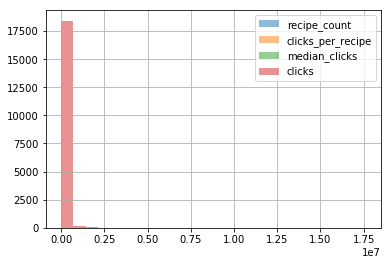

In [86]:
# Looking at the histograms in a single graph
import numpy as np
vote_efficiency["recipe_count"].hist(bins=25, alpha=0.5, label="recipe_count")  # blue
vote_efficiency["clicks_per_recipe"].hist(bins=25, alpha=0.5, label="clicks_per_recipe")  # orange/yellow
vote_efficiency["median_clicks"].hist(bins=25, alpha=0.5, label="median_clicks")  # green
# vote_efficiency["avg_rating"].hist(bins=25, alpha=0.5, label="avg_rating")  # red
vote_efficiency["clicks"].hist(bins=25, alpha=0.5, label="clicks")  # violet
plt.legend()
plt.show()

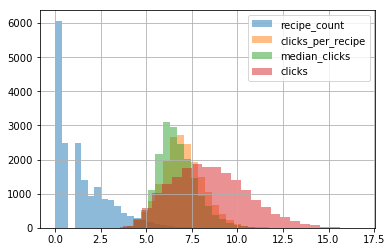

In [87]:
# How do the histograms look if we log transform all attributes?
users_transformed = pd.DataFrame(vote_efficiency)
users_transformed["recipe_count"].apply(np.log).hist(bins=25, alpha=0.5, label="recipe_count")  # still exponential
users_transformed["clicks_per_recipe"].apply(np.log).hist(bins=25, alpha=0.5, label="clicks_per_recipe")  
users_transformed["median_clicks"].apply(np.log).hist(bins=25, alpha=0.5, label="median_clicks")  
#users_transformed["avg_rating"].apply(np.log).hist(bins=25, alpha=0.5, label="avg_rating")  # still exponential, plot unfeasible
users_transformed["clicks"].apply(np.log).hist(bins=25, alpha=0.5, label="clicks")  
plt.legend()
plt.show()

As we can see, logarithmic transformations can help with only some of the attributes: clicks, clicks_per_recipe, median_clicks.
For these attributes, the distribution has become almost symmetric and more similar to a normal distribution. Thus, we could apply statistic models that assume a normal distribution (e.g. Principal Component Analysis) to these attributes with smaller errors. But even without further applying techniques, we can see that clicks_per_recipe, median_clicks and (total) clicks are overlapping in large parts, which shows that those distributions seem to be similar (especially clicks_per_recipe and median_clicks).

However, recipe_count and avg_rating still show an exponential distribution, even after transformation.

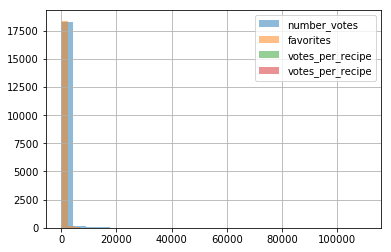

In [88]:
vote_efficiency['number_votes'].hist(bins=25, alpha=0.5, label="number_votes")
vote_efficiency['favorites'].hist(bins=25, alpha=0.5, label="favorites")
vote_efficiency['votes_per_recipe'].hist(bins=25, alpha=0.5, label="votes_per_recipe")
vote_efficiency['votes_per_recipe'].hist(bins=25, alpha=0.5, label="votes_per_recipe")
plt.legend()
plt.show()

In [89]:
# The following columns need to be adjusted, so they do not contain zeros anymore.
# votes_per_click consists of small numbers less than 1, thus needs to be scaled before adding 1
users_transformed = pd.DataFrame(vote_efficiency)
users_transformed['number_votes'] += 1
users_transformed['favorites'] += 1
users_transformed['votes_per_recipe'] += 1

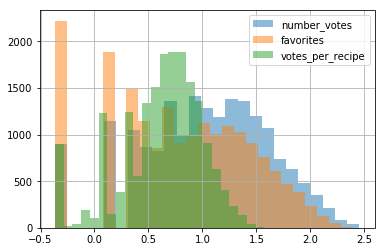

In [65]:
users_transformed['number_votes'].apply(np.log).apply(np.log).hist(bins=25, alpha=0.5, label="number_votes")  
users_transformed['favorites'].apply(np.log).apply(np.log).hist(bins=25, alpha=0.5, label="favorites")  
users_transformed['votes_per_recipe'].apply(np.log).apply(np.log).hist(bins=25, alpha=0.5, label="votes_per_recipe")  
users_transformed['votes_per_recipe'].apply(np.log).apply(np.log).hist(bins=25, alpha=0.5, label="votes_per_recipe") 
plt.legend()
plt.show()

We can see that some attributes still show an exponential distribution, even after logarithmic transofmration. The attribute votes_per_recipe even resembles a similarity to the poisson distribution.

##### How can we use this knowledge about the data distributions?

We now know how the different attributes are distributed. This means that we can we can select the recipes that are in the top 5% of the data with respect to their value in each of these attributes. This means that, we can now look for the top 5% recipes regarding their popularity in terms of clicks, votes and favorites.
Additionally, when we receive new user data, we can assess their success based on the distributions that we have calculated.

### Summary

We have found multiple ways to find users that have been successful in the community: by publishing a high amount of recipes or very popular ones. There are simple ways to find users that have collected many clicks or "favorites" with only a few recipes, being quite efficient in that regard. From a business perspective, this overview can be used to find recipes that provide a consistently high quality (by only selecting the recipes that come from users that perform well consistently), which is important to achieve a certain quality of service.

One simple way to find outstanding users is to look for outliers in this data. For example, we have shown that there is a significant correlation between the total number of recipes and the total number of votes, for a user. However, there will be users that have collected extraordinarily high numbers of votes for their recipe, thus making them an outlier in this comparison. These users most probably will have published more successful recipes than others.
Such users can be found looking for data points that lie above the regression line and can be reduced to a few by using margins or an error metric.
As an example, users that strongly deviate from the average will have a high mean squared error (MSE). These can be either the very good or very bad users, depending on the direction of the error. Thus, we can easily find the users that are interesting for our business.

Of course, we could just query for the recipes that have the most clicks and we would probably find the most popular recipes.
However, this extensive statistical analysis helps us to identify users that have been providing good recipes consistently, even if not all of them are among the top recipes regarding their total clicks.
This means that our analysis can be very valuable to find recipes with high and consistent quality.

Additionally, we can find users who might not have published successful mainstream recipes (like pancakes), but instead interesting niche foods, e.g. asian vegan cuisine, on a consistent quality level, if we do not only search for the highest clicks, but instead a consistent performance across multiple recipes.

### Single user analysis

Now, we want to apply our knowledge and pick one of these users seen in our analysis above.
First, we need to identify users that are in the top few of the multiple DataFrame that have been created.
Then, we can take a detailed look at the recipes he/she has published.

Show intersection of top 1000 in both, vote_efficiency and topusers:

In [184]:
# Intersection of top 1000 users in both dataframes:
intersect = vote_efficiency[:1000].index.intersection(topusers[:1000].index)
intersect

Index(['Noriana', 'rosinenschneckele', 'rezeptemaus', 'loewe_bs', 'luna-61',
       'gabi-63', 'olgabraun', 'tigerlilly63', 'Test00', 'labor',
       ...
       'Nachbarin', 'peter47', 'emi123', 'scarab', 'Chefkoch1940', 'simu',
       'Nadelmonster', 'ginamarie', 'dogeckhard', 'Oberin'],
      dtype='object', length=341)

Because we do not want to be overwhelmed by many hundreds of recipes, we can limit the results to the users that have published less than 100 recipes, then sort by clicks_per_recipe:

In [186]:
topusers.loc[(intersect.tolist())].loc[topusers['recipe_count'] <= 100].sort_values(by='clicks_per_recipe',ascending=False)

,recipe_count,clicks,clicks_per_recipe,median_clicks,avg_rating,number_votes,favorites,days,votes_per_recipe,clicks_per_day,fav_per_day,user
Rejerfan_55,90,1611575,17906.388889,9498.5,4.960111,3986,3552,3329,44.288889,483.956456,1.066667,Rejerfan_55
sweetyhoneypie,90,1391000,15455.555556,1965.0,4.987111,2756,3432,2673,30.622222,520.194465,1.283471,sweetyhoneypie
zimtzicke,86,1302073,15140.383721,6559.0,4.915814,3218,3215,3558,37.418605,365.853611,0.903344,zimtzicke
princess-tanja,100,1305825,13058.250000,3320.5,4.988100,4189,1813,2686,41.890000,485.978787,0.674731,princess-tanja
Backbiene,83,678908,8179.614458,2539.0,4.950602,3781,1353,3253,45.554217,208.637984,0.415796,Backbiene
susanpall,99,670050,6768.181818,1925.0,4.966364,4279,1232,3011,43.222222,222.460159,0.409031,susanpall
Nachbarin,75,486476,6486.346667,3325.0,4.962933,1604,1177,3192,21.386667,152.357031,0.368619,Nachbarin
Freizeitkoch_2373,86,544005,6325.639535,2785.5,4.979535,2381,843,2042,27.686047,266.277533,0.412629,Freizeitkoch_2373
hareg,82,510929,6230.841463,2240.5,4.976707,2243,641,2972,27.353659,171.856374,0.215607,hareg
Kuechen-Chefin,81,496671,6131.740741,1335.0,4.986667,2358,897,1461,29.111111,339.720246,0.613544,Kuechen-Chefin


We can see that user 'Rejerfan_55' has been quite successful with the 90 recipes that he/she has published.

In [189]:
# Show the top 20 recipes written by user "Rejerfan_55":

kochdf.loc[kochdf['user'] == 'Rejerfan_55'].sort_values(by='clicks',ascending=False).head(10)

,avg_rating,clicks,comment_number,date,day,difficulty,favorites,ingredients,month,name,number_votes,preparation,price,subtitle,time_mins,user,year
995,4.92,183829,31,2009-12-13,13,leicht,118,KÖTTBULLAR: 1000 g Hackfleisch gemisc...,12,Schwedische Fleischbällchen (Köttbullar) mit ...,74,1 Die sehr fein gewürfelten Zwiebeln in der...,€,Köttbullar med sås - so macht sie meine schwed...,90.0,Rejerfan_55,2009
106,4.91,172177,53,2009-04-22,22,leicht,329,Für eine Springform mit 26 cm Durchmesser:...,04,Schwedischer Schokoladenkuchen,113,1 Butter bei mittlerer Hitze in einem Topf ...,€,Kladdkaka - Rezept aus der Heimat meiner Mutter,65.0,Rejerfan_55,2009
329,4.83,71476,64,2009-10-30,30,leicht,203,"OBSTBELAG: 900 gr. Äpfel 0,5 Zi...",10,Apfelkuchen mit Mandelbelag,108,1 Zitronensaft und Wasser in eine Schüssel ...,€,Bienenstichartiger einfacher Apfelkuchen,90.0,Rejerfan_55,2009
9821,4.95,61159,31,2009-10-31,31,leicht,35,"OBSTBELAG: 900 gr. Äpfel 0,5 Zi...",10,Einfacher Apfelkuchen,57,1 Zitronensaft und Wasser in eine Schüssel ...,€,Mit Zimt und Zucker - schnell gemacht,70.0,Rejerfan_55,2009
2699,5.00,58239,22,2009-07-18,18,leicht,72,FÜR BODEN UND STREUSEL: 325 gr. Butte...,07,Blech: Johannisbeer-Quark-Streuselkuchen,51,1 Für den Boden und die Streusel zunächst B...,€ €,Fruchtig-saftiger Käse-Obstkuchen vom Blech,NaN,Rejerfan_55,2009
8225,5.00,53768,22,2013-01-12,12,mittel,39,Boden und Decke 100 g Margarine oder Bu...,01,Stachelbeertorte mit Mandelbaiserdecke,44,"Boden, Decke und Baisermasse 1 Aus den Z...",€ €,fruchtig-sahnige Torte,NaN,Rejerfan_55,2013
2340,4.92,52083,20,2009-07-29,29,leicht,77,HEFETEIG: 375 gr. Mehl 42 gr. He...,07,Blech: Blaubeer-Hefe-Schmandkuchen mit Streuseln,50,"1 Heidelbeeren waschen, verlesen und gut ab...",€,Saftiger Käse-Beerenkuchen,120.0,Rejerfan_55,2009
1303,4.93,51456,20,2009-04-15,15,leicht,106,"1000 gr. Spargel frisch und geschält, Sparge...",04,Spargel und Schinken gratiniert,60,1 Die Spargelschalen und Abschnitte in Salz...,€,Spargel mal überbacken,60.0,Rejerfan_55,2009
1893,5.00,50289,28,2009-06-21,21,leicht,87,Für den Boden: 200 gr. Mehl 100 ...,06,Blaubeer-Käsekuchen,64,"1 Boden:\rMehl, Butter, Zucker, Backpulver ...",€,Fruchtiger Käsekuchen für eine große Springform,120.0,Rejerfan_55,2009
1456,5.00,48132,28,2009-03-15,15,leicht,100,190 gr. Butter 200 gr. Zucker 25 g...,03,Blaubeer-Schokokuchen mit Quarkguss,74,"1 Butter, Zucker, Kakaopulver und Wasser in...",€,Saftiger Schokokuchen mit Heidelbeer- bzw. Bla...,30.0,Rejerfan_55,2009


In [190]:
# Provide meta information about user "Rejerfan_55"
kochdf.loc[kochdf['user'] == "Rejerfan_55"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 106 to 242348
Data columns (total 17 columns):
avg_rating        90 non-null float64
clicks            90 non-null int64
comment_number    90 non-null int64
date              90 non-null datetime64[ns]
day               90 non-null object
difficulty        90 non-null object
favorites         90 non-null int64
ingredients       90 non-null object
month             90 non-null object
name              90 non-null object
number_votes      90 non-null int64
preparation       90 non-null object
price             90 non-null object
subtitle          90 non-null object
time_mins         81 non-null float64
user              90 non-null object
year              90 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(5), object(9)
memory usage: 12.7+ KB


In [191]:
vote_efficiency.loc[vote_efficiency.index == 'Rejerfan_55']

,recipe_count,clicks,clicks_per_recipe,median_clicks,avg_rating,number_votes,favorites,days,votes_per_recipe,clicks_per_day,fav_per_day
Rejerfan_55,90,1611575,17906.388889,9498.5,4.960111,3989,3555,3329,47.288889,483.956456,1.066667


User "Rejerfan_55" has uploaded 90 recipes, of which he/she delivered 81 with a complete data set including the value for time_mins.
This user's most successful recipe is for swedish "kötbullar", which has received 183,829 clicks. However, his/her other recipes have been quite successfull as well, suggesting that the overall quality of this user's recipes seems to be high.

We can now compare these insights with the data of user "mareikus", which is one of the most efficient users, as shown above:

In [196]:
kochdf.loc[kochdf['user'] == 'mareikus'].sort_values(by='clicks',ascending=False)

,avg_rating,clicks,comment_number,date,day,difficulty,favorites,ingredients,month,name,number_votes,preparation,price,subtitle,time_mins,user,year
2,4.81,1428775,58,2009-02-19,19,leicht,845,2 Stk. Gemüsezwiebeln fein gehackt 2 St...,02,"Chili con Carne ""Spezial""",156,1 Die Zwiebeln und das Hack in dem Olivenöl...,€,Chili con Carne,45.0,mareikus,2009
22083,4.95,38075,6,2009-08-27,27,leicht,22,800 Gramm Mildes Sauerkraut 2 Stück Zwi...,08,Sauerkrautsuppe,21,"1 Die Zwiebeln, Knoblauch, und das Mett in...",€,Sauerkrautsuppe mit Tomate und Metteinlage,30.0,mareikus,2009
221,4.78,30104,23,2009-02-03,03,leicht,244,380 gr. Spaghetti 15 Stk. Zuckerschoten...,02,Gebratene Nudeln Asiatisch,55,"1 Den Porree, die Möhren , Knoblauch , Pepe...",€,Gebratene Nudeln Asiatiscuckerschoten und Lauch,30.0,mareikus,2009
8787,4.81,29746,5,2009-08-23,23,leicht,38,"4 Stk. Spare Rips ""Natur"" noch nicht eingele...",08,"The Best Rippchen ever, Spare Ribs mit Honig",21,1 Die Haut auf der Rückseite der rohen Ripp...,€,Marinierte Spare Rips mit Honig aus dem Bratsc...,330.0,mareikus,2009
22455,4.85,20340,22,2009-02-19,19,leicht,21,"4 Stk. Steinpilze frisch, gern auch mehr ...",02,Panierte Steinpilze im Butter gebraten,40,1 Man gehe in einen geeigneten Wald (in mei...,€,Panierte Steinpilze im Butter gebraten,20.0,mareikus,2009
7064,5.00,8415,20,2009-02-01,01,leicht,43,300 g Hühnerbrust 2 Stk. Möhren 2 ...,02,Asiatisches Hühner Curry,35,1 Hühnerbrust in Stücke schneiden und in So...,€,Hühnerbrust mit Kokosmilch und Basmatireis,40.0,mareikus,2009
29660,5.00,2669,17,2009-02-21,21,mittel,18,900 Gramm Kartoffeln 800 Gramm Zwiebeln...,02,Nucken,25,1 Zwiebel klein würfeln und in etwas Öl sch...,€,Kartoffelspeise vom meiner Oma aus Schlesien,40.0,mareikus,2009


In [195]:
vote_efficiency.loc[vote_efficiency.index == 'mareikus']

,recipe_count,clicks,clicks_per_recipe,median_clicks,avg_rating,number_votes,favorites,days,votes_per_recipe,clicks_per_day,fav_per_day
mareikus,7,1558124,222589.142857,29746.0,4.885714,356,1234,3316,53.428571,469.738921,0.371119


The user 'mareikus' however, has published only seven recipes, which should move average and median closer together. 
However, there is a significant difference between his/her most and least popular recipes (1,428,775 versus 2,669 clicks) and between average and median clicks (222,589.14 versus 29,746), meaning that this user has been more like a "one-hit wonder", having one very popular recipe and a few others, that have not been received well.

This proves that we can use the more complex approach above to find users that have been providing good recipes more consistently. Those users do not have a single recipe that has collected more than a million clicks, but instead many interesting recipes that have been popular consistently.

From a business perspective, we should aim to provide a mix of both worlds, having the selection of extremely popular recipes like pancakes and kötbullar, but at the same time enriching the recipe offer by high-quality and consistent recipes.

## Recipes

Now we can analyse further aspects of the recipe database, apart from the users. There are still multiple data fields that can provide interesting information. Aside from general statistics for creating an overview, the recipe titles and lists of ingredients provide text fields that could be "mined" for useful insights.

### Overview

We can first take a look at the simple statistics:

- Which recipes have collected the most clicks?

In [197]:
# Show top recipes according to clicks
kochdf['clicks'] = pd.to_numeric(kochdf['clicks'])
clickdf = pd.DataFrame(kochdf.sort_values(by='clicks',ascending=False))
clickdf.head(10)

,avg_rating,clicks,comment_number,date,day,difficulty,favorites,ingredients,month,name,number_votes,preparation,price,subtitle,time_mins,user,year
5,4.88,3866817,47,2009-11-16,16,leicht,778,"0,5 l Milch 4 Stk Eier 300 g Mehl ...",11,Pfannkuchen Grundrezept,143,1 Milch mit dem Mehl gut verrühren und die ...,€,einfach nur leckere Pfannkuchen,40.0,zaphi67,2009
32,4.92,1622581,78,2010-07-23,23,leicht,528,150 ml Prosecco 100 ml Mineralwasser mi...,07,"HUGO der Aperitif aus Südtirol - leicht, sprit...",207,Minzblätter in ein bauchiges Weinglas geben. ...,€,"der Aperitif aus Südtirol - leicht, spritzig.....",2.0,Anni2000,2010
1,4.52,1622373,25,2015-07-28,28,leicht,1370,3 Eier 120 gr. Schokolade weiß 120 ...,07,Japanischer Soufflé-Käsekuchen,21,"1 Die Eier trennen, das Eiweiß in eine größ...",€,Original-Rezept mit drei Zutaten,60.0,KB_Redaktion,2015
2,4.81,1428775,58,2009-02-19,19,leicht,845,2 Stk. Gemüsezwiebeln fein gehackt 2 St...,02,"Chili con Carne ""Spezial""",156,1 Die Zwiebeln und das Hack in dem Olivenöl...,€,Chili con Carne,45.0,mareikus,2009
109,4.91,1420889,22,2010-09-14,14,leicht,322,"3 Stk. Eier 3 EL Quark Süßstoff, de...",09,Quarkbrötchen ohne Kohlenhydrate,45,1 - Man trennt das Eigelb vom Eiweiß und gi...,€,luftig leichter Brotersatz oder auch als eine ...,5.0,saaahraaa,2010
245,4.74,1048014,22,2009-04-13,13,leicht,226,125 g Margarine 40 g Zucker 1 Päck...,04,Schneller Waffelteig,70,1 Die weiche Margarine mit dem Zucker und...,€,Mögen meine Kinder sehr gerne!,10.0,Brimsen,2009
259,4.85,967951,35,2010-01-03,03,leicht,223,6 Stück Frühlingszwiebeln frisch 2 Stüc...,01,die komplette Kohlsuppendiät = 7 Kilo in einer...,61,1 Dringend! Bitte immer die komplette Diät ...,€,weg mit dem Schlemmerspeck!!!,90.0,rickyundgaby,2010
28,4.84,848682,80,2008-06-09,09,leicht,494,1 Glas Selleriesalat 3 Äpfel 300 ...,06,Schichtsalat,232,1 Wichtig: Den Salat einen Tag vorher zuber...,€,Beliebt auf jeder Party,42.0,Kruemelmonster,2008
426,4.93,833965,33,2011-11-18,18,leicht,177,"1,2 kg Rehkeule ohne Knochen Für die Marina...",11,Rehkeule - butterzart bei Niedrigtemperatur,81,Vorbereitungen am Vortag: 1 Wie die Zuta...,€ €,"Kerntemperatur 60° C, Garzeit ca. 3,5 Std.",NaN,Huengerchen,2011
52,4.92,800233,11,2014-01-14,14,leicht,457,12 große Schweineschnitzel Salz und Pfeffe...,01,Schnitzelpfanne,38,"1 Schnitzel waschen, trocken tupfen und mit...",€,Partygericht,120.0,claire,2014


We could do the same for:

- Which recipes have the highest number of favorites?

In [246]:
# Another example for sorting:
# Sort recipes by favorites:
# clickdf.sort_values(by=['avg_rating', 'number_votes'],ascending=[False, False]).head(10)
clickdf.sort_values(by=['favorites'],ascending=[False]).head(10)

,avg_rating,clicks,comment_number,date,day,difficulty,favorites,ingredients,month,name,number_votes,preparation,price,subtitle,time_mins,user,year,days
4,4.60,220759,409,2008-06-16,16,leicht,1674,150 gr. Mehl 2 TL Backpulver 125 g...,06,Der Schnellste Bienenstich,572,"1 Aus Mehl, Backpulver, Zucker Vanillezuc...",€,None,40.0,Mella80,2008,3546
20,4.81,111661,238,2008-10-02,02,leicht,1658,260 g Mehl 75 g Schoko-Tröpfchen 2 ...,10,Baileys Muffins,404,"1 Ofen auf 180 Grad vorheizen.\rMehl, Sch...",€ €,None,NaN,schnibbelliese,2008,3438
13,4.68,291163,321,2008-08-13,13,leicht,1462,1 Dose Milchmädchencreme [gezuckerte Dosenmi...,08,Raffaello Pralinen,435,Die Milchmädchencreme mit den Kokosraspeln ve...,€,Pralinen,23.0,butterfly86,2008,3488
1,4.52,1622373,25,2015-07-28,28,leicht,1370,3 Eier 120 gr. Schokolade weiß 120 ...,07,Japanischer Soufflé-Käsekuchen,21,"1 Die Eier trennen, das Eiweiß in eine größ...",€,Original-Rezept mit drei Zutaten,60.0,KB_Redaktion,2015,948
0,4.83,101092,59,2009-07-26,26,leicht,925,500 gr. Hackfleisch 3 Zucchini 1 ...,07,Zucchini-Hackauflauf mit Frischkäse und Spätzle,141,1 Das Hackfleisch mit etwas Margarine in...,€,"guter Appetit-Auflauf, der auch mit gekochten ...",45.0,romantica,2009,3141
3,4.84,308066,23,2009-06-25,25,leicht,873,800 gr. Kartoffeln 125 ml Milch 125 ...,06,Kartoffelgratin -klassisch-,75,1 Kartoffeln schälen und auf einem Gurken...,€,mit ein bisschen Speck,65.0,Meerjungfrau,2009,3172
14,4.85,239142,8,2012-11-09,09,leicht,867,200 gr. Rind Hackfleisch frisch 200 gr....,11,Spaghetti Bolognese,20,1 Als erstes die rote Zwiebeln schälen und ...,€,Das Familienrezept der Familie Cuomo,320.0,RTL Punkt 12 Lieblingsgerichte,2012,1939
2,4.81,1428775,58,2009-02-19,19,leicht,845,2 Stk. Gemüsezwiebeln fein gehackt 2 St...,02,"Chili con Carne ""Spezial""",156,1 Die Zwiebeln und das Hack in dem Olivenöl...,€,Chili con Carne,45.0,mareikus,2009,3298
7,4.91,512590,20,2009-10-07,07,leicht,818,2 Tassen Mehl 1 Tasse Zucker 2 Stk...,10,Grundrezept Muffins,45,1 Backofen auf 200Grad vorheizen und Muffin...,€,None,25.0,sabi7224,2009,3068
5,4.88,3866817,47,2009-11-16,16,leicht,778,"0,5 l Milch 4 Stk Eier 300 g Mehl ...",11,Pfannkuchen Grundrezept,143,1 Milch mit dem Mehl gut verrühren und die ...,€,einfach nur leckere Pfannkuchen,40.0,zaphi67,2009,3028


- Which recipes have been discussed the most? (highest comment number)

In [35]:
# Show top 10 most discussed recipes
kochdf.sort_values(by='comment_number',ascending=False).head(10)

,avg_rating,clicks,comment_number,date,day,difficulty,favorites,ingredients,month,name,number_votes,preparation,price,subtitle,time_mins,user,year
4,4.60,220759,409,2008-06-16,16,leicht,1674,150 gr. Mehl 2 TL Backpulver 125 g...,06,Der Schnellste Bienenstich,572,"1 Aus Mehl, Backpulver, Zucker Vanillezuc...",€,None,40.0,Mella80,2008
13,4.68,291163,321,2008-08-13,13,leicht,1462,1 Dose Milchmädchencreme [gezuckerte Dosenmi...,08,Raffaello Pralinen,435,Die Milchmädchencreme mit den Kokosraspeln ve...,€,Pralinen,23.0,butterfly86,2008
20,4.81,111661,238,2008-10-02,02,leicht,1658,260 g Mehl 75 g Schoko-Tröpfchen 2 ...,10,Baileys Muffins,404,"1 Ofen auf 180 Grad vorheizen.\rMehl, Sch...",€ €,None,NaN,schnibbelliese,2008
6,4.81,101183,175,2008-07-29,29,leicht,729,125 ml Eierlikör 200 gr. Schokolade wei...,07,Eierlikörkugeln,288,1 Palmin (Butter) und Schokolade langsam ...,€ €,Pralinen ... echt lecker!!!,NaN,Florinda,2008
775,4.99,5341,145,2009-01-26,26,leicht,134,Für den Boden: 100 g Butter 75 g...,01,Asti-Erdbeer-Torte,219,1 Für den Teig weiche Butter geschmeidig rü...,€ €,Ein Hit auf jedem Kuchenbuffet...,84.0,None,2009
43,4.79,54730,130,2008-12-01,01,leicht,481,500 gr Zwiebeln 4 Stck. Schweineschnitz...,12,Zwiebel-Sahne-Schnitzel,226,1 Die Zwiebel abziehen und in Ringe schneid...,€,mit Käse überbacken,30.0,Monali,2008
29,4.76,178984,130,2009-01-30,30,leicht,530,für den Teig: 100 Gramm Butter 80 ...,01,Allerbester Rhabarberkuchen♥,244,"Den Rhabarber schälen, in kleine Stücke schne...",€ €,mit Vanillecreme und Streusel,NaN,Schokoprinzessin,2009
3809,4.94,11640,129,2009-03-28,28,mittel,60,120 Stück Marzipantaler 70 Stück Rohkos...,03,DAS ULTIMATIVE DESSERTBUFFET,193,Letzten Samstag war die Überraschungsparty zu...,€,"da bin ich wirklich stolz drauf, perfekt für H...",NaN,Divina,2009
236,4.84,11945,126,2008-11-25,25,mittel,236,Teig: 4 Eiweiß 4 Esslöffel Wass...,11,Ananas-Bananen-Torte,273,1 Eiweiß zu Schnee schlagen. Kaltes Wasser ...,€ €,"auch als ""Besser als Sex"" - Torte bekannt",NaN,loewe_bs,2008
369,4.98,22729,117,2009-10-27,27,leicht,189,2 Baguettes 200 gr Butter 4 Eier...,10,APPETITHÄPPCHEN - GEFÜLLTE BAGUETTES,223,1 Soviel vorab: Normalerweise braucht man 2...,€,mit WOW-Garantie!,40.0,luna-61,2009


### Data preparation

We can further improve the data's usability by adding another feature (days passed since publication) or reducing the data to a subset, so computations can go faster.
We can also export the dataset in an Excel file, for example, so we can easily integrate the data in other programmes for further evaluation.

In [200]:
# We can add the amount of days each recipe has been online already:
clickdf['days'] = clickdf['date'].apply(days_passed)

In [36]:
# Select top 100000 recipes according to clicks to filter the most popular recipes 
# (This is useful if the computation time is too long with the full data set)

# clickdf = pd.DataFrame(kochdf.sort_values(by='clicks',ascending=False).head(100000))
# clickdf.head(10)

In [247]:
# Export to Excel for use in Tableau or other programme
writer = pd.ExcelWriter('kochdf.xlsx')
kochdf.to_excel(writer,'Recipes')
writer.save()

### Exploration

In [204]:
# How many recipes of each difficulty level are available?
clickdf['difficulty'].value_counts()

leicht             383183
mittel              28181
schwer               1961
nicht angegeben       444
Name: difficulty, dtype: int64

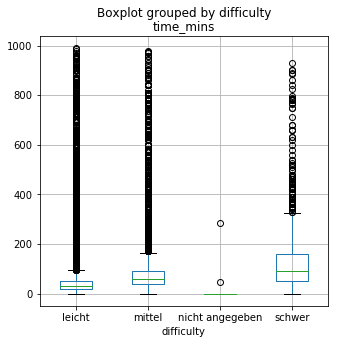

In [205]:
# Show boxplots for recipe duration (time_mins) w.r.t. recipe difficulty 
# (leicht = easy, mittel = medium, schwer = difficult)
kochdf.boxplot(column='time_mins', by = 'difficulty', figsize=(5,5))

It is obvious that these values do not have a normal or even symmetric distribution, but rather an exponential one, as we have seen above as well. Due to that reason, boxplots only provide limited insight.

However, if we still interpret this plot, we can see that the average duration of recipes increase together with their difficulty. For easy recipes, we can see more outliers (outside the whisker) as there are more data points in this category.

Similar as above, we can create one DataFrame only for the numeric data in the recipes:

In [237]:
# Show only numerical features per recipe in a new data frame
numerics = pd.DataFrame()
numerics['avg_rating'] = pd.to_numeric(clickdf['avg_rating'])
numerics['clicks'] = pd.to_numeric(clickdf['clicks'])
numerics['comment_number'] = pd.to_numeric(clickdf['comment_number'])
numerics['days'] = pd.to_numeric(clickdf['date'].apply(days_passed))
numerics['favorites'] = pd.to_numeric(clickdf['favorites'])
numerics['time_mins'] = pd.to_numeric(clickdf['time_mins'])
numerics['number_votes'] = pd.to_numeric(clickdf['number_votes'])
numerics.head(10)

,avg_rating,clicks,comment_number,days,favorites,time_mins,number_votes
5,4.88,3866817,47,3028,778,40.0,143
32,4.92,1622581,78,2779,528,2.0,207
1,4.52,1622373,25,948,1370,60.0,21
2,4.81,1428775,58,3298,845,45.0,156
109,4.91,1420889,22,2726,322,5.0,45
245,4.74,1048014,22,3245,226,10.0,70
259,4.85,967951,35,2980,223,90.0,61
28,4.84,848682,80,3553,494,42.0,232
426,4.93,833965,33,2296,177,NaN,81
52,4.92,800233,11,1508,457,120.0,38


In [215]:
numerics.describe()

,avg_rating,clicks,comment_number,days,favorites,time_mins,number_votes
count,402570.000000,4.137690e+05,413769.000000,413769.000000,413769.000000,279540.000000,413769.000000
mean,4.940516,2.353766e+03,6.309794,2736.573859,6.605676,47.625839,18.295897
std,0.226773,1.149429e+04,8.158715,716.918874,15.736548,62.461644,19.822087
min,1.000000,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,3.400000e+02,1.000000,2414.000000,1.000000,20.000000,5.000000
50%,5.000000,7.570000e+02,3.000000,2987.000000,3.000000,30.000000,11.000000
75%,5.000000,1.909000e+03,8.000000,3258.000000,7.000000,60.000000,24.000000
max,5.000000,3.866817e+06,409.000000,3646.000000,1674.000000,990.000000,572.000000


We can quickly check for correlations using Pearson's r for linear dependencies and Spearman's rho for dependencies that can be modeled with a monotonic function.

In [224]:
# Are there correlations between these numerics? 
# Calculate Pearson's r using our function from above:
num_pear, num_pearp = calculate_pearson(numerics)
num_peardf = pd.DataFrame(num_pear, columns=numerics.columns, index=numerics.columns)
num_peardf

C:\Users\buz_t\Anaconda3\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


,avg_rating,clicks,comment_number,days,favorites,time_mins,number_votes
avg_rating,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clicks,NaN,1.000000,0.126004,-0.010656,0.468628,NaN,0.130872
comment_number,NaN,0.126004,1.000000,-0.027270,0.398991,NaN,0.890076
days,NaN,-0.010656,-0.027270,1.000000,-0.032954,NaN,-0.110217
favorites,NaN,0.468628,0.398991,-0.032954,1.000000,NaN,0.385824
time_mins,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_votes,NaN,0.130872,0.890076,-0.110217,0.385824,NaN,1.000000


In [225]:
# Respective p-Values for significance
num_pearpdf = pd.DataFrame(num_pearp, columns=numerics.columns, index=numerics.columns)
num_pearpdf

,avg_rating,clicks,comment_number,days,favorites,time_mins,number_votes
avg_rating,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.0
clicks,1.0,0.000000e+00,0.000000e+00,7.136760e-12,0.000000e+00,1.0,0.0
comment_number,1.0,0.000000e+00,0.000000e+00,6.537613e-69,0.000000e+00,1.0,0.0
days,1.0,7.136760e-12,6.537613e-69,0.000000e+00,8.932096e-100,1.0,0.0
favorites,1.0,0.000000e+00,0.000000e+00,8.932096e-100,0.000000e+00,1.0,0.0
time_mins,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.0
number_votes,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0


Pearson's r only shows a significant dependency between comment_number and number_votes. This means that users that leave a comment on the recipe page usually also vote for the recipe's rating and vice versa. 
We can also see that this correlation metric does not support avg_rating and time_mins, as these columns include zeros or None values.

For nonlinear dependencies, we can use Spearman's rho:

In [218]:
# Are there correlations between these numerics? 
from scipy.stats.stats import spearmanr
num_speardf = pd.DataFrame(spearmanr(numerics)[0], columns=numerics.columns, index=numerics.columns)
num_speardf

,avg_rating,clicks,comment_number,days,favorites,time_mins,number_votes
avg_rating,1.000000,-0.115025,-0.227447,-0.091530,-0.207836,-0.001168,-0.238047
clicks,-0.115025,1.000000,0.290388,-0.068914,0.558837,0.047996,0.300250
comment_number,-0.227447,0.290388,1.000000,-0.069886,0.599846,0.108814,0.851901
days,-0.091530,-0.068914,-0.069886,1.000000,-0.022262,0.030729,-0.290388
favorites,-0.207836,0.558837,0.599846,-0.022262,1.000000,0.084995,0.597514
time_mins,-0.001168,0.047996,0.108814,0.030729,0.084995,1.000000,0.071441
number_votes,-0.238047,0.300250,0.851901,-0.290388,0.597514,0.071441,1.000000


In [220]:
# Show the p-Values for Spearman's rho
num_speardf = pd.DataFrame(spearmanr(numerics)[1], columns=numerics.columns, index=numerics.columns)
num_speardf

,avg_rating,clicks,comment_number,days,favorites,time_mins,number_votes
avg_rating,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,4.524377e-01,0.0
clicks,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.565885e-209,0.0
comment_number,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0
days,0.000000,0.000000e+00,0.0,0.000000e+00,1.598415e-46,5.293438e-87,0.0
favorites,0.000000,0.000000e+00,0.0,1.598415e-46,0.000000e+00,0.000000e+00,0.0
time_mins,0.452438,1.565885e-209,0.0,5.293438e-87,0.000000e+00,0.000000e+00,0.0
number_votes,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0


Spearman's rho, while confirming the relationship between comment_number and number_votes, shows a few more interesting dependencies for the pairs clicks/favorites, comment_number/favorites and favorties/number_votes. The rho value for these pairs is not high enough to assume a strong dependency, but still it can hint at a relation that also makes sense:

Recipes usually gather more clicks, comments and rating votes, if more people have marked them as favorites. This is especially interesting as the pairwise dependencies of clicks, comments and rating votes among each other are much lower than each of their dependencies with the number of favorites.
This could mean that the number of favorites a recipe has collected has an impact on the recipe's success regarding clicks, comments and ratings. 

The reason for this could be a simple design decision that has been taken on the website of kochbar.de: When searching for recipes, a user can order by the following attributes: Availability of a picture, rating, clicks, duration (time_mins), date and favorites. As we have seen in the analysis above, the rating is not very helpful, as there are many recipes with 5 stars. Additionally, sorting by the ratings also brings recipes to the first page that have just one or two recipes, which is not very helpful.
Thus, the only way to order by their quality is using the number of favorites per recipe. Of course, one could also use the number of clicks, but if a recipe gets a lot of clicks and thus high traffic, it does not necessarily imply a good quality post. However, if a user has tried out a recipe and then took the time to come back to that page, mark it as a favorite and possibly leave a comment or rating, this suggests that the user has enjoyed cooking the recipe.

To verify this theory we can also take a look at the scatter matrix for this DataFrame:

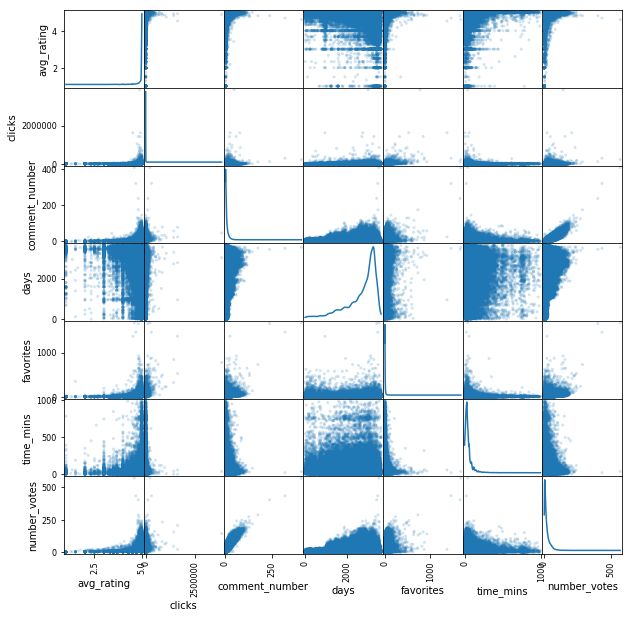

In [226]:
from pandas.plotting import scatter_matrix
_ = scatter_matrix(numerics, alpha=0.2, figsize=(10, 10), diagonal='kde')

As we have exponential distributions, logarithmic transformations might provide better insight, as the scatter matrix will be more easily interpretable.
First, we need a function to add 1 to a Series, so there are no zeros left, which would be problematic when computing the logarithm. Then, we can create a new DataFrame that holds the transformed attributes.
It does not make sense to transform all attributes, as that would lead to NaN values in some of the cases. In particular, avg_rating and time_mins contain None values, which lead to NaNs. Neither would it be useful to transform the days attribute, which shows for how many days a recipe has been online. This attribute is of much more use when not transformed, as we can directly interpret its relationship to the other attributes.

In [242]:
# Function for adding 1 to an input:
def add_one(x):
    x += 1
    return x

In [243]:
import numpy as np
log_numerics = pd.DataFrame()
log_numerics['avg_rating'] = pd.to_numeric(clickdf['avg_rating'])
log_numerics['clicks'] = pd.to_numeric(clickdf['clicks']).apply(add_one).apply(np.log)
log_numerics['comment_number'] = pd.to_numeric(clickdf['comment_number']).apply(add_one).apply(np.log)
log_numerics['days'] = pd.to_numeric(clickdf['date'].apply(days_passed))
log_numerics['favorites'] = pd.to_numeric(clickdf['favorites']).apply(add_one).apply(np.log)
log_numerics['time_mins'] = pd.to_numeric(clickdf['time_mins'])
log_numerics['number_votes'] = pd.to_numeric(clickdf['number_votes']).apply(add_one).apply(np.log)

log_numerics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 413769 entries, 5 to 378990
Data columns (total 7 columns):
avg_rating        402570 non-null float64
clicks            413769 non-null float64
comment_number    413769 non-null float64
days              413769 non-null int64
favorites         413769 non-null float64
time_mins         279540 non-null float64
number_votes      413769 non-null float64
dtypes: float64(6), int64(1)
memory usage: 25.3 MB


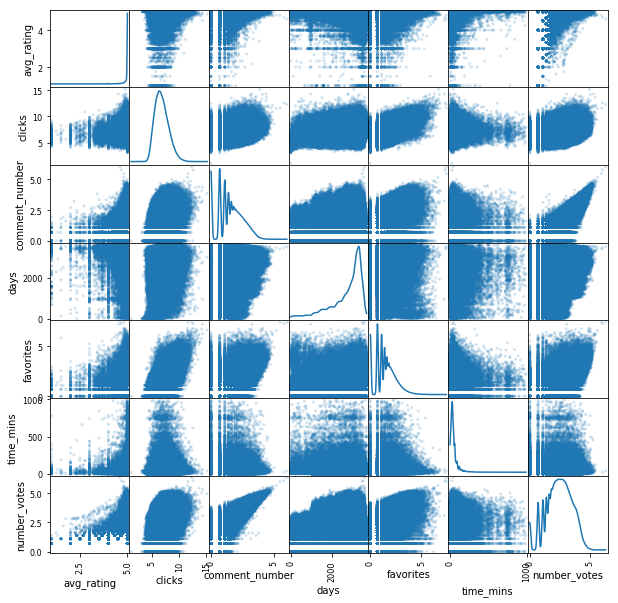

In [244]:
_ = scatter_matrix(log_numerics, alpha=0.2, figsize=(10, 10), diagonal='kde')

In [245]:
from scipy.stats.stats import spearmanr
num_speardf = pd.DataFrame(spearmanr(log_numerics)[0], columns=log_numerics.columns, index=log_numerics.columns)
num_speardf

,avg_rating,clicks,comment_number,days,favorites,time_mins,number_votes
avg_rating,1.000000,-0.115025,-0.227447,-0.091530,-0.207836,-0.001168,-0.238047
clicks,-0.115025,1.000000,0.290388,-0.068914,0.558837,0.047996,0.300250
comment_number,-0.227447,0.290388,1.000000,-0.069886,0.599846,0.108814,0.851901
days,-0.091530,-0.068914,-0.069886,1.000000,-0.022262,0.030729,-0.290388
favorites,-0.207836,0.558837,0.599846,-0.022262,1.000000,0.084995,0.597514
time_mins,-0.001168,0.047996,0.108814,0.030729,0.084995,1.000000,0.071441
number_votes,-0.238047,0.300250,0.851901,-0.290388,0.597514,0.071441,1.000000


We can see that the distributions have shifted due to the log transformation and some correlations can be identified more easily in the scatter matrix. Spearman's rho has not changed for the transformed dataset, which shows that this correlation coefficient is robust to monotonous transformations.
This representation of the transformed dataset confirms the assumptions about the dependencies that we have made further above.

### Title analysis

What can we learn from the recipe titles? We can either use the titles as they are (which does not provide very valuable results) or split the titles up into single words and perform further steps like word count or generating new features.
For this, the data has to be cleaned further.

In [248]:
# Show most common recipe names (Single-word titles)
kochdf['name'].value_counts().head(10) 

Nudelsalat          338
Tiramisu            247
Kartoffelsalat      235
Käsekuchen          231
Kartoffelsuppe      208
Pizzabrötchen       195
Apfelkuchen         193
Käsesuppe           190
Schichtsalat        190
Kräuterbutter       179
Kürbissuppe         178
Zwiebelkuchen       177
Nudelauflauf        173
Eierlikörkuchen     171
Eiersalat           159
Rotweinkuchen       150
Reissalat           141
Gyrossuppe          133
Eierlikör           132
Kartoffelgratin     130
Name: name, dtype: int64

From over 330,000 recipes, the most frequent name is "Nudelsalat" occurring 338 times, which is interesting but not very significant.
Thus, we need to split up multi-word titles and count all words seperately.

While doing this, we also need to clean out characters/symbols and stopwords that do not help in identifying the recipe's content. This will be shown in the next steps:

In [249]:
# Creates a list of single words from a list of multi-word names, removing most-common symbols
nameslist = []
for x in range(len(clickdf)):
    words = clickdf.iloc[x]['name']
    # filter unnecessary characters
    for char in ['"','-','=','!','(',')','.','♥',',',':','~','„','“','/','–','&','+',';','*','☆']:
        words = words.replace(char,'')
    words = words.split(' ',20)  # Split up titles with up to 20 whitespaces
    nameslist.extend(words)
    
# Remove empty elements, which occur when there is a space or symbol at the end of a name
nameslist = list(filter(None, nameslist))  
nameslist[:10]

['Pfannkuchen',
 'Grundrezept',
 'HUGO',
 'der',
 'Aperitif',
 'aus',
 'Südtirol',
 'leicht',
 'spritziglecker',
 'Japanischer',
 'SouffléKäsekuchen',
 'Chili',
 'con',
 'Carne',
 'Spezial',
 'Quarkbrötchen',
 'ohne',
 'Kohlenhydrate',
 'Schneller',
 'Waffelteig']

In [250]:
# list of german stop words from: https://www.ranks.nl/stopwords/german
# for removing words like "and", "or", etc.
text_file = open("stopwords.txt", "r")
stopwords  = text_file.readlines()
for i in range(len(stopwords)):
    stopwords[i] = stopwords[i].replace('\n','')

In [251]:
# filter unnecessary stopwords from nameslist
for stop in stopwords:
    nameslist = list(filter(lambda k: stop != k, nameslist))
    
nameslist[:10]

['Pfannkuchen',
 'Grundrezept',
 'HUGO',
 'Aperitif',
 'Südtirol',
 'leicht',
 'spritziglecker',
 'Japanischer',
 'SouffléKäsekuchen',
 'Chili',
 'con',
 'Carne',
 'Spezial',
 'Quarkbrötchen',
 'ohne',
 'Kohlenhydrate',
 'Schneller',
 'Waffelteig',
 'komplette',
 'Kohlsuppendiät']

In [252]:
# Now, we can filter all list entries that contain numbers, so there are only words left.
# For that, we first need to define a function that can detect numbers in a string:
import re
def containsNumbers(string):
    return bool(re.search(r'\d', string))

In [253]:
# Now we can filter nameslist with the new function:
nameslist = [w for w in nameslist if not containsNumbers(w)]    

In [254]:
# Now we can count the words in nameslist:
from collections import Counter
namecount = Counter(nameslist)
namecount.most_common(10)

[('Salat', 6018),
 ('Art', 4645),
 ('Gemüse', 4370),
 ('Gefüllte', 4030),
 ('Kuchen', 3752),
 ('Tomaten', 3418),
 ('Spaghetti', 3218),
 ('la', 3186),
 ('Spargel', 2870),
 ('Nudeln', 2785)]

In [255]:
# This still contains french and italian stop words (e.g. "á", "la", "alla"), as such words are often used in recipe titles.
# Additionally, there are still some German stopwords which have not been filtered before because they contain capital letters
# The following list has been extracted manually from the 1000 most frequent words
more_stopwords = ('Art', 'a', 'la', 'de', 'á', 'à', 'ohne', 'mal', 'lecker', 'Mein', 'dazu', 
                  'ala', 'au', 'alla', 'ganz', 'schnelle', 'al', 'di', 'Die', 'Der', 'Das', 
                  'MIT', 'Mit', 'a’la', 'Ein', 'so', 'u', 'e', 'E', 'nur', 'D', 'A', 'Co', 
                  'I', 'um', 'ihn', 'and', 'Aus', 'II', 'Nr', 'Style', 'gut', 'ca', 'UND', 'con')

for stop in more_stopwords:
    nameslist = list(filter(lambda k: stop != k, nameslist))

In [256]:
# 'Oma´s' 'Oma' 'Omas' 'Oma`s' "Oma's" are still in the list
for w in nameslist:
    if w == 'Oma´s' or w == 'Oma' or w == 'Oma`s' or w == 'Omas':
        w = "Oma's"

In [257]:
# Count the words in nameslist, creates a dictionary with word counts
from collections import Counter
counts = Counter(nameslist)
counts.most_common(10)

[('Salat', 6018),
 ('Gemüse', 4370),
 ('Gefüllte', 4030),
 ('Kuchen', 3752),
 ('Tomaten', 3418),
 ('Spaghetti', 3218),
 ('Spargel', 2870),
 ('Nudeln', 2785),
 ('Käse', 2522),
 ('Lachs', 2464)]

In [403]:
# The counter can also be converted into a pandas DataFrame.
# (This provides a higher functionality than the limited Counter object.)
countsdf = pd.Series(dict(counts), name='count')
countsdf = countsdf.reset_index().sort_values(by='count', ascending=False)
countsdf.columns = ['word', 'count']
countsdf.index = countsdf['word']
countsdf = countsdf.drop('word', axis=1)

# Add log transfored counts:
import numpy as np
countsdf['log_count'] = countsdf['count'].apply(np.log)
countsdf.head(10)

,count,log_count
word,,
Salat,6018,8.702510
Gemüse,4370,8.382518
Gefüllte,4030,8.301522
Kuchen,3752,8.230044
Tomaten,3418,8.136811
Spaghetti,3218,8.076515
Spargel,2870,7.962067
Nudeln,2785,7.932003
Käse,2522,7.832808


In [404]:
# Statistics for word counts
countsdf.describe()

,count,log_count
count,175034.000000,175034.000000
mean,5.302381,0.452623
std,48.351462,0.914430
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.693147
max,6018.000000,8.702510


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E955455A90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001E955FEEA90>]], dtype=object)

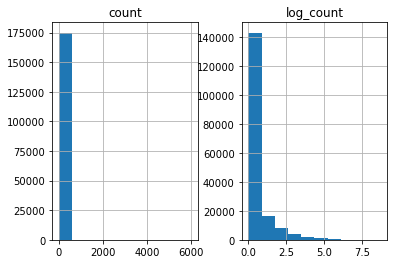

In [405]:
countsdf.hist()

There is a total of 177,559 distinct words used in titles (after cleaning out stop words as shown above).
Similar to the attributes viewed before, the words in recipe titles are exponentially distributed as well.
Thus, when building a feature set from these words by one hot encoding, we should focus on picking a subset of the most frequent words, e.g. all words that occur at least 100 times in the data set. 

Additionally, we can see that even after performing a logarithmic transformation, the word counts still have a strong exponential distribution. Thus, the transformation does not help here.

In [260]:
i = 0
for w in counts.most_common(100000):
    i += 1
    if w[1] == 99:
        print(w)
        print(i)
        break

('selbstgemachter', 99)
1255


The first 1254 words occur at least 100 times in the data set.

In [396]:
countsdf[:1254].describe()

,count
count,1254.000000
mean,345.334131
std,450.467992
min,100.000000
25%,134.000000
50%,199.000000
75%,360.750000
max,6018.000000


#### Generating new features from recipe titles
##### How can we split up the titles in the DataFrame?
This can be done using the techniques shown above:

In [262]:
# Creating a new data frame, because the features will be high-dimensional
namedf = pd.DataFrame()
#namedf['user'] = clickdf['user']
namedf['name'] = clickdf['name']
namedf.index = clickdf.index

# namelistdf = pd.DataFrame()
namedf.head(10)

,name
5,Pfannkuchen Grundrezept
32,"HUGO der Aperitif aus Südtirol - leicht, sprit..."
1,Japanischer Soufflé-Käsekuchen
2,"Chili con Carne ""Spezial"""
109,Quarkbrötchen ohne Kohlenhydrate
245,Schneller Waffelteig
259,die komplette Kohlsuppendiät = 7 Kilo in einer...
28,Schichtsalat
426,Rehkeule - butterzart bei Niedrigtemperatur
52,Schnitzelpfanne


In [263]:
namelist = []
for w in namedf['name']:
    for char in ['"','-','=','!','(',')','.','♥',',',':','~','„','“','/','–','&','+',';','*','☆']:
        if char in w:
            w = w.replace(char,' ')
    namelist.append(w)

In [264]:
tmplist = []

for title in namelist:
    
    title = title.split(' ')
    
    # Filter empty list entries
    title = list(filter(None, title)) 
    
    # Filter all stop words defined above
    for stop in stopwords:
        title = list(filter(lambda k: stop != k, title))
    for stop in more_stopwords:
        title = list(filter(lambda k: stop != k, title))
    
    # Remove numbers from titles
    title = [w for w in title if not containsNumbers(w)] 
    
    tmplist.append(title)

In [265]:
namedf['name'] = tmplist
namedf.head(10)

,name
5,"[Pfannkuchen, Grundrezept]"
32,"[HUGO, Aperitif, Südtirol, leicht, spritzig]"
1,"[Japanischer, Soufflé, Käsekuchen]"
2,"[Chili, Carne, Spezial]"
109,"[Quarkbrötchen, Kohlenhydrate]"
245,"[Schneller, Waffelteig]"
259,"[komplette, Kohlsuppendiät, Kilo, Woche, abneh..."
28,[Schichtsalat]
426,"[Rehkeule, butterzart, Niedrigtemperatur]"
52,[Schnitzelpfanne]


In [266]:
tmplist2 = []

for l in tmplist:
    for w in l:
        tmplist2.append(w)

from collections import Counter
count = Counter(tmplist2)
titlewords = count.most_common(100)
titlewords[:10]

[('Salat', 10167),
 ('Kuchen', 7177),
 ('Gemüse', 7160),
 ('Tomaten', 6548),
 ('Torte', 5991),
 ('Käse', 5410),
 ('Auflauf', 5178),
 ('Kartoffel', 5036),
 ('Suppe', 4693),
 ('Sauce', 4457)]

In [267]:
count['Kuchen']

7177

In [268]:
# From each title, pick the two most common words to generate two new columns

toplist1 = []
toplist2 = []

for title in namedf['name']:
    try:
        topword1 = title[0]
        topword2 = title[1]
    except IndexError:
        try: 
            topword1 = title[0]
            topword2 = title[0]
        except IndexError:
            pass
    for word in title:
        if count[word] > count[topword1]:
            topword2 = topword1
            topword1 = word
        if count[word] < count[topword1] & count[word] > count[topword2]:
            topword2 = word
    if topword1 == topword2:
        topword2 = None
    toplist1.append(topword1)
    toplist2.append(topword2)
    
namedf['top1'] = toplist1
namedf['top2'] = toplist2
namedf.head(10)

,name,top1,top2
5,"[Pfannkuchen, Grundrezept]",Pfannkuchen,Grundrezept
32,"[HUGO, Aperitif, Südtirol, leicht, spritzig]",leicht,Aperitif
1,"[Japanischer, Soufflé, Käsekuchen]",Käsekuchen,Soufflé
2,"[Chili, Carne, Spezial]",Chili,Carne
109,"[Quarkbrötchen, Kohlenhydrate]",Quarkbrötchen,Kohlenhydrate
245,"[Schneller, Waffelteig]",Schneller,Waffelteig
259,"[komplette, Kohlsuppendiät, Kilo, Woche, abneh...",Kilo,komplette
28,[Schichtsalat],Schichtsalat,None
426,"[Rehkeule, butterzart, Niedrigtemperatur]",Rehkeule,butterzart
52,[Schnitzelpfanne],Schnitzelpfanne,None


In [269]:
# print(count["Curry"], count["Hähnchen"])
# namedf.loc['Topfenparfait'.isin(namedf['name']), 'top1']
print(namedf['top1'].value_counts().head(10), namedf['top2'].value_counts().head(10))

Salat        9877
Gemüse       6973
Kuchen       6919
Tomaten      5916
Torte        5410
Auflauf      4432
Käse         4408
Sauce        3837
Suppe        3670
Kartoffel    3624
Name: top1, dtype: int64 Kartoffel    1283
Apfel        1171
Schoko       1031
Zucchini     1027
Sahne        1011
Schinken      941
Kokos         849
Joghurt       824
Curry         792
BiNe`         791
Name: top2, dtype: int64


How many unique words are there in the top title words?

In [271]:
print(namedf['top1'].describe()) #36k unique words in top1 column
print("-----")
print(namedf['top2'].describe()) #58k unique words in top2 column

count     413769
unique     36450
top        Salat
freq        9877
Name: top1, dtype: object
-----
count        340828
unique        57827
top       Kartoffel
freq           1283
Name: top2, dtype: object


In [286]:
toplist1.extend(toplist2)
# len(toplist1)  # 421k words
top = Counter(toplist1)
len(top)  # 77k unique words in both columns combined

76606

By creating two new columns from the most frequent pair of words for each recipe, we have performed a very simple version of dimensionality reduction. In further analysis, we can now use these two words as a short identifier for the contents of each recipe.

We can now also add our pre-trained FastText vectors to namedf:

In [459]:
import fasttext
word_model = fasttext.load_model('prep_model.bin')

def lookup_vector(word):
    return word_model[word]

In [449]:
import fasttext
word_model = fasttext.skipgram('word_embeddings/preps.txt', 'prep_model', thread=8)

In [456]:
#namedf['vector'] = namedf['top1'].apply(lookup_vector)
#lookup_vector('Schinken')
word_model['Brot'][:10]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

#### One-hot Encoding

For attributes that do not have too many distinct values, which repeat many times, one can use one-hot encoding. This technique creates a binary column for every distinct and fills a data point's entry with a one, if it contains the specified value.

For this purpose, we can create a function that encodes specific values from one column in a DataFrame into a new columns, of which each is named after that value.

In [417]:
def encode_onehot(df, col, words):
    def contains_val(l):
        if val in l:
            return 1
        else: return 0

    for val in words:
        df[val] = df[col].apply(contains_val)

In [386]:
# Example usage:
test = pd.DataFrame(['c', ['a', 'b'], ['c', 'a'], ['b', 'a', 'c']])
encode_onehot(test, 0, ['a', 'b', 'c'])
test

,0,a,b,c
0,c,0,0,1
1,"[a, b]",1,1,0
2,"[c, a]",1,0,1
3,"[b, a, c]",1,1,1


We can use this function to encode the recipe ingredients in the next section. We only need to specify the DataFrame, the column that contains the values to be encoded and a list of selected values to encode, e.g. a list of most common words.

### Ingredient analysis

In [387]:
# ingredients = pd.DataFrame(columns=[clickdf['ingredients'],clickdf.index])
ingredients = pd.DataFrame(clickdf['ingredients'],index = clickdf.index)

In [411]:
remove = ["l","g", "g.", "kg", "Kilogramm", "Gramm", "gr.", "gr", 
          "Stk.", "Stk", "ml", "Glas", "Gläser", "Päckchen", 
          "Milliliter", "Stück", "große", "kleine", "frisch", 
          "weich", "Zweige", "Würfel", "EL", "TL", "kl.", "cl", 
          "Schuss", "Esslöffel", "Teelöffel", "-", "a", "ca", "ca.", 
          "ganz", "ganze", "ganzes", "wichtig", "!!!!!", "lecker",
          "halb", "Liter", "Bund", "Dosen", "Für", "für", "ltr.", 
          "Ltr.", ":-)", "½", "(", ")", "/", "&", "Prise", 
          "Packung", "Schuß", "evtl.", "Scheiben", "Streifen", 
          "andere", "Kg", "min.", "a'", "(ma)", "etwas", "lieber", 
          "je", "ob", "dunkel", "hell", "beides", "oder", "cm", "kalt", 
          "gehackt", "gerieben", "EL.", "TL.", "ml.", "el", ";-)", 
          "tl", "Essl", "Pr", "Eßl", "ggf", "Größe", "M", "L", 
          "eventuell", "Das", "El", "Pck", "Pk", "TK", "frische", 
          "gemischt", "fein", "gemahlen", "Dose", "KB", "z", "B", 
          "kl", "klein", "geschält", "tiefgefroren", "Tl", "dl", 
          "flüssig", "grob", "extra", "de", "%", "gramm", "weiche", 
          "geriebener", "unbehandelt", "Zehen", "Form", "voll",
          "Zum", "Etwas", "Und", "vlt", "Msp", "rot", "getrocknet", 
          "gepresst", "Becher", "gewürfelt", "gestrichen", "rot", 
          "rote", "weiß", "grün", "weiß", "geschnitten", "lauwarm", 
          "ohne", "Teel", "gehackte", "abgetropft", "geraspelt", 
          "gemahlene", "evtl", "schwarz", "Scheibe", "gegart", "braune", 
          "Zutaten", "Spritzer", "gelb", "Geschmack", "festkochend", 
          "weiße", "vergine", "scharf", "Stange", "brauner", "Gr", 
          "glatt", "getrocknete", "mittelscharf", "edelsüß", "Pulver", 
          "trocken", "Sauce", "Zweig", "Soße", "meinem", "Blatt", 
          "Stangen", "mittelgroße", "Flasche", "lauwarm", "Freiland", 
          "grüne", "Bio", "Schale", "Teig", "Tassen", "gekocht", "Mühle", 
          "Tasse", "Konserve", "Rote", "gelbe", "frische", "Füllung", 
          "Deko", "Konserve", "gemahlener", "gesiebt", "geräuchert", 
          "braun", "Tropfen", "Belag", "Messerspitze", "Beutel", "St", 
          "grosse", "weißer", "fettarm", "Saure", "Type", "siehe", 
          "geriebene", "schwarzer", "abgeriebene", "einige", "Blätter", 
          "saure", "dag", "Bd"]
# remove stopwords as well

len(remove)

215

Due to a lack of standardisation on the website, the ingredients lists can also hold a large variety of different words for describing the same things, which can be considered stop words as well. As such a list for filtering these words needs to be created manually by looking into the data set, the process can go on for a very long time. Thus, this list includes the 215 most frequent stop words that have been selected manually from the data, but is still far from being final, so there will still be many words in the ingredients lists that should be removed for better data quality.
There are also users that write the ingredients in capital letters only, or write them according to old spelling standards (as those have changed multiple times in German language over the last years). 

In [390]:
counter = 0
average = 0
for words in ingredients['ingredients']:
    average += len(words.split(' '))
    counter += 1
    
print(average / counter) # Average number of "words" is 74.8 (includes numbers and stopwords)

74.82990509197161


In [391]:
# Multiple cleaning steps to do
inglist = []

for words in ingredients['ingredients']:
    
    for char in ['"','-','=','!','(',')','.','♥',',',':','~','„','“','/','–','&','+',';','*','☆']:
        if char in words:
            words = words.replace(char,' ')
    
    words = words.split(' ')  # Split up words
    
    # Filter empty list entries
    words = list(filter(None, words)) 
    
    # Filter all stop words defined above
    for stop in stopwords:
        words = list(filter(lambda k: stop != k, words))
    for stop in remove:
        words = list(filter(lambda k: stop != k, words))
    
    # Remove numbers
    words = [w for w in words if not containsNumbers(w)] 
    
    inglist.append(words)

inglist[:3]

[['Milch', 'Eier', 'Mehl', 'Öl', 'Salz', 'Zucker'],
 ['Prosecco',
  'Mineralwasser',
  'viel',
  'Kohlensäure',
  'Holunderblütensirup',
  'Minze',
  'Limettenscheibe',
  'Eiswürfel',
  'Belieben'],
 ['Eier', 'Schokolade', 'Frischkäse', 'Doppelrahmstufe'],
 ['Gemüsezwiebeln',
  'Knoblauchzehen',
  'Tomatenfruchtfleisch',
  'Stücken',
  'geschälte',
  'Tomaten',
  'Tomatenmark',
  'Tube',
  'Kidney',
  'Bohnen',
  'Mais',
  'Kreuzkümmel',
  'Lorbeerblätter',
  'Kochen',
  'entfernen',
  'Chili',
  'Schote',
  'Rotwein',
  'Körnige',
  'Gemüsebrühe',
  'Kakaopulver',
  'Nesquick',
  'Salz',
  'Pfeffer',
  'Oregano',
  'Gehacktes',
  'Olivenöl',
  'Zucker'],
 ['Eier', 'Quark', 'Süßstoff', 'flüssigen'],
 ['Margarine',
  'Zucker',
  'Vanillinzucker',
  'Eier',
  'Mehl',
  'Backpulver',
  'Milch'],
 ['Frühlingszwiebeln',
  'Tomaten',
  'Weißkohl',
  'Paprika',
  'Staudensellerie',
  'Petersilie',
  'Lauchstange',
  'Ingwer',
  'Kümmel',
  'Lorbeerblätter',
  'Olivenöl',
  'Pfeffer',
  'Salz'

In [392]:
# How many words are left in each ingredient list (on average)?
counter = 0
average = 0
for words in inglist:
    average += len(words)
    counter += 1
    
print(average / counter) # Average number of keywords is now only approx. 13.4 (may still include stop words)

13.411918244237727


In [393]:
# Create a flat list for counting the words
inglist2 = []
for l in inglist:
    for w in l:
        inglist2.append(w)

In [394]:
# Word count for ingredients can help finding more stopwords
from collections import Counter
ingcounter = Counter(inglist2)
ingcounter.most_common(10)

[('Salz', 261366),
 ('Pfeffer', 204670),
 ('Zucker', 152607),
 ('Butter', 122956),
 ('Mehl', 100812),
 ('Eier', 84847),
 ('Zwiebel', 80967),
 ('Sahne', 78086),
 ('Öl', 64126),
 ('Milch', 61667)]

In [395]:
len(ingcounter)  # 107k distinct words in ingredients

107623

#### Applying these methods to the DataFrame for feature generation

After we have discovered the tools to split up ingredients, we can apply these techniques to the DataFrame.

In [428]:
# Creating a new data frame, because the features will be high-dimensional
ingredf = pd.DataFrame()
ingredf['ingredients'] = clickdf['ingredients']
ingredf['ingredients'] = clickdf['ingredients']
ingredf.index = clickdf.index

ingredf.head(10)

,ingredients
5,"0,5 l Milch 4 Stk Eier 300 g Mehl ..."
32,150 ml Prosecco 100 ml Mineralwasser mi...
1,3 Eier 120 gr. Schokolade weiß 120 ...
2,2 Stk. Gemüsezwiebeln fein gehackt 2 St...
109,"3 Stk. Eier 3 EL Quark Süßstoff, de..."
245,125 g Margarine 40 g Zucker 1 Päck...
259,6 Stück Frühlingszwiebeln frisch 2 Stüc...
28,1 Glas Selleriesalat 3 Äpfel 300 ...
426,"1,2 kg Rehkeule ohne Knochen Für die Marina..."
52,12 große Schweineschnitzel Salz und Pfeffe...


In [429]:
# Cleaning
def clean_ingredients(text):    
    # Remove characters
    for char in ['"','-','=','!','(',')','.','♥',',',':','~','„','“','/','–','&','+',';','*','☆']:
        if char in text:
            text = text.replace(char,' ')
            
    # Split up words
    text = text.split(' ')  
    
    # Filter empty list entries
    text = list(filter(None, text)) 
    
    # Filter all stop words defined above
    for stop in stopwords:
        text = list(filter(lambda k: stop != k, text))
    for stop in remove:
        text = list(filter(lambda k: stop != k, text))
    
    # Remove numbers
    text = [t for t in text if not containsNumbers(t)]
    
    return text

In [430]:
ingredf['inglist'] = ingredf['ingredients'].apply(clean_ingredients)
ingredf.head(10)

,ingredients,inglist
5,"0,5 l Milch 4 Stk Eier 300 g Mehl ...","[Milch, Eier, Mehl, Öl, Salz, Zucker]"
32,150 ml Prosecco 100 ml Mineralwasser mi...,"[Prosecco, Mineralwasser, viel, Kohlensäure, H..."
1,3 Eier 120 gr. Schokolade weiß 120 ...,"[Eier, Schokolade, Frischkäse, Doppelrahmstufe]"
2,2 Stk. Gemüsezwiebeln fein gehackt 2 St...,"[Gemüsezwiebeln, Knoblauchzehen, Tomatenfrucht..."
109,"3 Stk. Eier 3 EL Quark Süßstoff, de...","[Eier, Quark, Süßstoff, flüssigen]"
245,125 g Margarine 40 g Zucker 1 Päck...,"[Margarine, Zucker, Vanillinzucker, Eier, Mehl..."
259,6 Stück Frühlingszwiebeln frisch 2 Stüc...,"[Frühlingszwiebeln, Tomaten, Weißkohl, Paprika..."
28,1 Glas Selleriesalat 3 Äpfel 300 ...,"[Selleriesalat, Äpfel, Schinken, Porree, Eisbe..."
426,"1,2 kg Rehkeule ohne Knochen Für die Marina...","[Rehkeule, Knochen, Marinade, ltr, Glühwein, R..."
52,12 große Schweineschnitzel Salz und Pfeffe...,"[Schweineschnitzel, Salz, Pfeffer, Butter, Mar..."


In [436]:
# Use most common words for one hot encoding:
encode_onehot(ingredf, 'inglist', pd.DataFrame(ingcounter.most_common(1000))[0].tolist())
ingredf.head(10)

,ingredients,inglist,Salz,Pfeffer,Zucker,Butter,Mehl,Eier,Zwiebel,Sahne,...,heiße,Spiralnudeln,Schweinemett,tiefgekühlt,steht,Noilly,viel,Kandiszucker,Riesling,Pudding
5,"0,5 l Milch 4 Stk Eier 300 g Mehl ...","[Milch, Eier, Mehl, Öl, Salz, Zucker]",1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
32,150 ml Prosecco 100 ml Mineralwasser mi...,"[Prosecco, Mineralwasser, viel, Kohlensäure, H...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,3 Eier 120 gr. Schokolade weiß 120 ...,"[Eier, Schokolade, Frischkäse, Doppelrahmstufe]",0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2 Stk. Gemüsezwiebeln fein gehackt 2 St...,"[Gemüsezwiebeln, Knoblauchzehen, Tomatenfrucht...",1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
109,"3 Stk. Eier 3 EL Quark Süßstoff, de...","[Eier, Quark, Süßstoff, flüssigen]",0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
245,125 g Margarine 40 g Zucker 1 Päck...,"[Margarine, Zucker, Vanillinzucker, Eier, Mehl...",0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
259,6 Stück Frühlingszwiebeln frisch 2 Stüc...,"[Frühlingszwiebeln, Tomaten, Weißkohl, Paprika...",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,1 Glas Selleriesalat 3 Äpfel 300 ...,"[Selleriesalat, Äpfel, Schinken, Porree, Eisbe...",0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
426,"1,2 kg Rehkeule ohne Knochen Für die Marina...","[Rehkeule, Knochen, Marinade, ltr, Glühwein, R...",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52,12 große Schweineschnitzel Salz und Pfeffe...,"[Schweineschnitzel, Salz, Pfeffer, Butter, Mar...",1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Feature Generation

We can now use the generated DataFrames to create a new one that contains the relevant data of those. This can be used during trend analysis and with data mining algorithms. 

In [437]:
# Join extracted features for further analysis
featuredf = namedf.join(clickdf['date'])
featuredf = featuredf.join(clickdf['favorites'])
featuredf = featuredf.join(clickdf['clicks'])
featuredf = featuredf.join(ingredf)
featuredf = featuredf.drop(['name', 'ingredients'], axis=1)
featuredf.head(10)

,top1,top2,date,favorites,inglist,Salz,Pfeffer,Zucker,Butter,Mehl,...,heiße,Spiralnudeln,Schweinemett,tiefgekühlt,steht,Noilly,viel,Kandiszucker,Riesling,Pudding
5,Pfannkuchen,Grundrezept,2009-11-16,778,"[Milch, Eier, Mehl, Öl, Salz, Zucker]",1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
32,leicht,Aperitif,2010-07-23,528,"[Prosecco, Mineralwasser, viel, Kohlensäure, H...",0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,Käsekuchen,Soufflé,2015-07-28,1370,"[Eier, Schokolade, Frischkäse, Doppelrahmstufe]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Chili,Carne,2009-02-19,845,"[Gemüsezwiebeln, Knoblauchzehen, Tomatenfrucht...",1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
109,Quarkbrötchen,Kohlenhydrate,2010-09-14,322,"[Eier, Quark, Süßstoff, flüssigen]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
245,Schneller,Waffelteig,2009-04-13,226,"[Margarine, Zucker, Vanillinzucker, Eier, Mehl...",0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
259,Kilo,komplette,2010-01-03,223,"[Frühlingszwiebeln, Tomaten, Weißkohl, Paprika...",1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,Schichtsalat,None,2008-06-09,494,"[Selleriesalat, Äpfel, Schinken, Porree, Eisbe...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
426,Rehkeule,butterzart,2011-11-18,177,"[Rehkeule, Knochen, Marinade, ltr, Glühwein, R...",1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52,Schnitzelpfanne,None,2014-01-14,457,"[Schweineschnitzel, Salz, Pfeffer, Butter, Mar...",1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Bonus: Wordcloud

For visualisation, we can use the extracted recipe titles and ingredients to create wordclouds:

In [54]:
from wordcloud import WordCloud

# Generate one string that includes all final title words
titletext = ""
for w in tmplist2:
    titletext += " "+w

#### For recipe titles

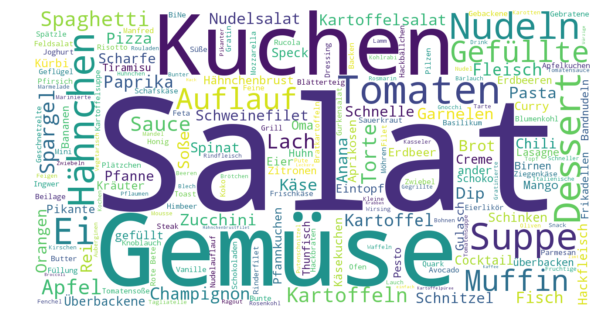

In [55]:
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color="white", max_font_size=360, width=1920, height=1080).generate(titletext)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
wordcloud.to_file("dishes3.png")
plt.show()

#### For ingredients

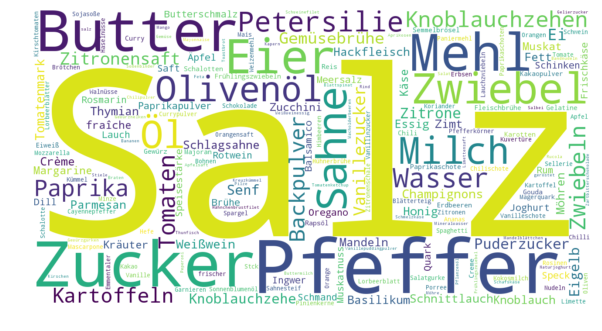

In [34]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_font_size=800, width=1920, height=1080).generate_from_frequencies(ingcounter)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
wordcloud.to_file("ingredients3.png")
plt.show()

### Conclusion: Explorative Analysis

We have used explorative techniques to understand the user and recipe data more deeply and have found interesting dependencies.
We can use this knowledge to find the best recipes on the platform much more precisely, as we do not only rely on a single metric, but instead can find users that have published good recipes consistently.
Using our scatter matrices we can easily see where to find outliers in the data and some of these outliers will be the users that have performed extraordinarily well.

We have also discovered that a high number of clicks a recipe has collected does not necessarily imply a good quality. Instead, those are most probably the popular mainstream recipes that many people choose because of the dish itself, not necessarily the quality of the recipe. As recipes with many clicks are also more likely to attract more users and gather more clicks, that attribute is distributed exponentially, which is why we might overlook many good recipes if we only judge them by the amount of clicks.
To find the actually good recipes that people have enjoyed and decided to come back to for rating them and leaving a comment, we rather should look for recipes with a high amount of favorites (users that have marked that recipe as a favorite).

For selecting a larger number of recipes with consistent quality, we have seen a technique how to select users that have provided good recipes consistently.

The text analysis has provided us insights about:
- which words are used most frequently in recipe titles, which can hint at the most popular recipes and dishes among authors,
- which ingredients are used most frequently, thus are most relevant for a large amount of recipes

Additionally, we can use the generated features during further analysis with machine learning algorithms.

# 2. Trend Analysis

This part of the analysis will focus on how the data has changed and evolved over time.
For this purpose, we have two different time axes available for usage:

- the publication date of each recipe
- monthly snapshots of the data over the last 6 months

2009    154938
2010     75107
2008     52884
2011     45238
2012     29305
2013     22163
2014     15854
2015      7877
2016      5209
2017      4528
2018       666
Name: year, dtype: int64


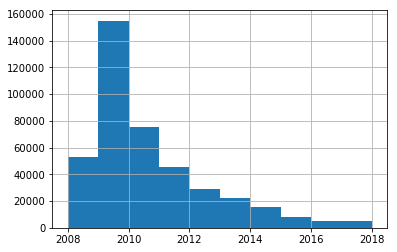

In [9]:
kochdf['year'] = pd.to_numeric(kochdf['year'])
print(kochdf['year'].value_counts())
kochdf['year'].hist()

# 3. Data Mining / Machine Learning

The final section of the analysis will present the preparation and application of an exemplary machine learning algorithm on the dataset. Due to the limited frame of this project, only one algorithm can be presented in detail.
For this purpose, the method of clustering has been selected.

Clustering can be useful to find similar data points in a dataset that does not have any class labels beforehand, which makes it an unsupervised learning algorithm.
This means that we can use clustering to group the recipes in clusters that contain similar dishes. 